In [1]:
#----------------------------------------
#libraries that need to be installed extra , if already do not exists
#mglearn, pandas, numpy, sklearn
#----------------------------------------
#---------------------------------------------------------------------------
#FLAG used in each code block mean 
#                1: that can be executed at any machine with final csv file
#                0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

#import libaries

import matplotlib.pyplot as plt 
import mglearn, csv, random , matplotlib
import pandas as pd
import numpy as np 
import seaborn as sns
import time
from datetime import datetime
from sklearn.utils import shuffle



from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectFromModel

#classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

#clustering
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap
from scipy.cluster.hierarchy import linkage, dendrogram

#data scaling 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from collections import defaultdict

#accuracy score metric
from sklearn.metrics import accuracy_score


#cosine similatiry metric
from sklearn.metrics.pairwise import cosine_similarity

#covariance with ellipticEnvelope (anomaly detection)
from sklearn.covariance import EllipticEnvelope

#word2vec
from gensim.models import Word2Vec

#oversampling 
from imblearn.combine import SMOTETomek

#jupiter display dataset without limits 
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
def filter_users_by_label(df):
    u_before = df.shape[0]
    user_ids = df.iloc[:,-1]
    df = df.iloc[:,:-1]
    target = df.iloc[:,-1]
    df = df.iloc[:,:-1]
    
    filtered_bots = set([int(x.split(" ")[0]) for x in open("../data/bot_labels_jan.txt","r").read().split("\n") if x != ''])
    filtered_clear = set([int(x.split(" ")[0]) for x in open("../data/clear_labels_jan.txt","r").read().split("\n") if x != ''])

    keep_ids = []
    for x in np.where(target == 2)[0]:
        if user_ids[x]  in filtered_bots:
            keep_ids.append(x)
            target[x] = 1

    for x in np.where(target == 0)[0]:
        if user_ids[x] in filtered_clear:
            keep_ids.append(x)
            target[x] = 0
    
    df["target"] = target 
    df["user_id"] = user_ids
    print("Check for duplicates :{} and {}. Should be equeal".format(len(keep_ids), len(set(keep_ids))))
    df = df.iloc[keep_ids]
    df.reset_index(drop=True, inplace=True)
    u_after = df.shape[0]
    print("Dataset filtering. Users before:{} users after:{}".format(u_before, u_after))
    return df
    

def graph_features(df):
    graph = [(np.int64(x.split("\"")[1]), np.int64(x.split("\"")[3])) for x in open("../data/ret_graph.dot", "r").read().split("\n") if "->" in x ]
    #identify self loops in graphs 
    self_loop = set([a for a,b in graph if a == b]) 
    
    #Get node degree data with weighted and un-weighted
    degree_data = { np.int64(x.split(",")[0]) : x.split(",")[3:] for x in open("../data/ret_data_degree.csv","r").read().split("\n")[1:] if x != ""}
    
    #Assemble all features in single DataFrame
    df["rt_self"]  = np.array([1 if x in self_loop else 0 for x in df["user_id"] ])
    df["in_degree"] = np.array([degree_data[x][0] if x in degree_data else 0 for x in df["user_id"] ])
    df["out_degree"] = np.array([degree_data[x][1] if x in degree_data else 0 for x in df["user_id"] ])
    df["w_in_degree"] = np.array([degree_data[x][3] if x in degree_data else 0 for x in df["user_id"] ])
    df["w_out_degree"] = np.array([degree_data[x][4] if x in degree_data else 0 for x in df["user_id"] ])
    df["w_degree"] = np.array([degree_data[x][5] if x in degree_data else 0 for x in df["user_id"] ])
    return df
                               
def word_2_vec(dataFrame):
    model = Word2Vec.load("../data/word2vec_1_new.model")
    
    dataframes = [dataFrame]
    
    labels_to_remove = []
    labels = ["mst_fr_ment_tw_word_", "mst_fr_ment_rt_word_", 
              "mst_fr_hs_tw_word_", "mst_fr_hs_rt_word_", 
              "words_frq_tw_", "words_frq_rt_"]
    for label in labels:
        for i in range(1,4):
            labels_to_remove.append(label+str(i))
            temp = []
            for word in dataFrame[label+str(i)]:
                if word == "_":
                    score = [0]*10
                elif label == "words_frq_rt_" and i == 2 and word != word:
                    score = model.wv['nan']
                else:
                    score = model.wv[word]
                temp.append(score)
            col = ["{}{}_{}".format(label,i,k) for k in range(10)]
            dataframes.append(pd.DataFrame(temp, columns=col))
    
    
    #Merge all dataframes and drop the text based columns that was used in word2vec model
    merged = pd.concat(dataframes, axis="columns")
    merged = merged.drop(labels_to_remove, axis="columns")
    return merged

def combine_data():
    df = pd.read_csv("../data/new_vectors_new.csv",sep = '\t', header=0)
    
    #read labels from botometer and keep only users that agree to been bot or removed according to botometer
    df = filter_users_by_label(df)
    
    #Read graph features 
    df = graph_features(df)
                               
    #transform word features with word2vec to numerical vectors  
    df = word_2_vec(df)
    df = df.drop(["followers.1"], axis="columns")
    print("Final dataset shape:{}".format(df.shape))
    
    #save csv dataframe in order to reduce computation since the dataset remain same within multiple executions
    df.to_csv (r'../data/features_large_with_words.csv', index = False, header=True)
    

combine_data()

Check for duplicates :11836 and 11836. Should be equeal
Dataset filtering. Users before:86927 users after:11836
Final dataset shape:(11836, 328)


## Read data from csv file with features and merge it with graph features and labels from label file

### Use of mix of bot labels from Botsentiel and Botometer
### !!!! 
### Important combine_data are used only on Alex machine since i have all files that is combined to final csv file with all features no need to run 
### !!!!

In [3]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

def filter_users_by_label(df):
    u_before = df.shape[0]
    user_ids = df.iloc[:,-1]
    df = df.iloc[:,:-1]
    target = df.iloc[:,-1]
    df = df.iloc[:,:-1]
    
    filtered_bots = set([int(x.split(" ")[0]) for x in open("../data/bot_labels_jan.txt","r").read().split("\n") if x != ''])
    filtered_clear = set([int(x.split(" ")[0]) for x in open("../data/clear_labels_jan.txt","r").read().split("\n") if x != ''])

    keep_ids = []
    for x in np.where(target == 2)[0]:
        if user_ids[x]  in filtered_bots:
            keep_ids.append(x)
            target[x] = 1

    for x in np.where(target == 0)[0]:
        if user_ids[x] in filtered_clear:
            keep_ids.append(x)
            target[x] = 0
    
    df["target"] = target 
    df["user_id"] = user_ids
    print("Check for duplicates :{} and {}. Should be equeal".format(len(keep_ids), len(set(keep_ids))))
    df = df.iloc[keep_ids]
    df.reset_index(drop=True, inplace=True)
    u_after = df.shape[0]
    print("Dataset filtering. Users before:{} users after:{}".format(u_before, u_after))
    return df
    

def graph_features(df):
    graph = [(np.int64(x.split("\"")[1]), np.int64(x.split("\"")[3])) for x in open("../data/ret_graph.dot", "r").read().split("\n") if "->" in x ]
    #identify self loops in graphs 
    self_loop = set([a for a,b in graph if a == b]) 
    
    #Get node degree data with weighted and un-weighted
    degree_data = { np.int64(x.split(",")[0]) : x.split(",")[3:] for x in open("../data/ret_data_degree.csv","r").read().split("\n")[1:] if x != ""}
    
    #Assemble all features in single DataFrame
    df["rt_self"]  = np.array([1 if x in self_loop else 0 for x in df["user_id"] ])
    df["in_degree"] = np.array([degree_data[x][0] if x in degree_data else 0 for x in df["user_id"] ])
    df["out_degree"] = np.array([degree_data[x][1] if x in degree_data else 0 for x in df["user_id"] ])
    df["w_in_degree"] = np.array([degree_data[x][3] if x in degree_data else 0 for x in df["user_id"] ])
    df["w_out_degree"] = np.array([degree_data[x][4] if x in degree_data else 0 for x in df["user_id"] ])
    df["w_degree"] = np.array([degree_data[x][5] if x in degree_data else 0 for x in df["user_id"] ])
    return df
                               
def word_2_vec(dataFrame):
    model = Word2Vec.load("../data/word2vec_1_new.model")
    
    dataframes = [dataFrame]
    
    labels_to_remove = []
    labels = ["mst_fr_ment_tw_word_", "mst_fr_ment_rt_word_", 
              "mst_fr_hs_tw_word_", "mst_fr_hs_rt_word_", 
              "words_frq_tw_", "words_frq_rt_"]
    for label in labels:
        for i in range(1,4):
            labels_to_remove.append(label+str(i))
            temp = []
            for word in dataFrame[label+str(i)]:
                if word == "_":
                    score = [0]*10
                elif label == "words_frq_rt_" and i == 2 and word != word:
                    score = model.wv['nan']
                else:
                    score = model.wv[word]
                temp.append(score)
            col = ["{}{}_{}".format(label,i,k) for k in range(10)]
            dataframes.append(pd.DataFrame(temp, columns=col))
    
    
    #Merge all dataframes and drop the text based columns that was used in word2vec model
    merged = pd.concat(dataframes, axis="columns")
    merged = merged.drop(labels_to_remove, axis="columns")
    return merged

def combine_data():
    df = pd.read_csv("../data/new_vectors_new.csv",sep = '\t', header=0)
    
    #read labels from botometer and keep only users that agree to been bot or removed according to botometer
    df = filter_users_by_label(df)
    
    #Read graph features 
    df = graph_features(df)
                               
    #transform word features with word2vec to numerical vectors  
    df = word_2_vec(df)
    df = df.drop(["followers.1"], axis="columns")
    print("Final dataset shape:{}".format(df.shape))
    
    #save csv dataframe in order to reduce computation since the dataset remain same within multiple executions
    df.to_csv (r'../data/features_large_with_words.csv', index = False, header=True)
    

In [8]:
#---------------------------------------------------------------------------
#FLAG -> 1: that can be executed at any machine with final csv file and 
#--------------------------------------------------------------------------

#scale  data of each portion of dataset (train, evaluation and test)
def scale_data(train, evaluation, test):
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
    # scale train and test
    X_eval = pd.DataFrame(scaler.transform(evaluation), columns = evaluation.columns)
    X_test = pd.DataFrame(scaler.transform(test), columns = test.columns)
    return X_train, X_eval, X_test

#oversample dataset portion
#used in separated form for train and evalution datasets
#do not use in test data at all
def oversample(data, target):
    smk = SMOTETomek()
    data, target = smk.fit_sample(data, target)
    return data, target

#load twitter features
def read_data(filename, verbose=False):
    #read the csv file that was combined with word2vec and graph features
    df = pd.read_csv(filename, header=0)
    
    
    #random shuffle the dataframe
    df = shuffle(df)
    
    #extract user id from dataframe
    user_ids = df["user_id"]
    
    #extract target from datafrmae
    target = df["target"]
    
    df = df.drop(["user_id","target"], axis="columns")
    
    #make stratified train and test split 80/20 
    X_train, X_test, y_train, y_test = train_test_split(df, 
                                                        target,
                                                        test_size=0.2,
                                                        stratify=target)
    
    #scale features values with MinMaxScaler
    #scaler = StandardScaler()
    #scaler.fit(X_train)
    #scale train and test
    #X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)
    
    #after scaling cast from np.array to dataframe again
    X_test = pd.DataFrame(X_test, columns = df.columns)
    X_train = pd.DataFrame(X_train, columns = df.columns)
    
    return X_train, y_train, X_test, y_test



## Feature selection 

In [4]:
#---------------------------------------------------------------------------
#FLAG -> 1: that can be executed at any machine with final csv file and 
#--------------------------------------------------------------------------

def kbest_features(data, labels,n_features):
    #scaler = MinMaxScaler()
    #scaled_data = scaler.fit(data).transform(data)

    bestfeatures = SelectKBest(score_func=chi2, k=n_features)
    fit = bestfeatures.fit(data, labels)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(n_features,'Score'))  #print 10 best features
    res = featureScores.nlargest(n_features,'Score')
    #print(dir(res))
    res = [x[0] for x in res.values]
    
    embeded_rf_support = [True if x in res else False for x in df.columns.tolist()]
    #res = [x[0] for x in res.values]
    #res = res.get_support()
    #embeded_rf_feature = data.loc[:,res].columns.tolist()
    return data[res]

def rforest_features(data, labels, n_features):
    #scaler = MinMaxScaler()
    #scaled_data = scaler.fit(data).transform(data)

    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=n_features)
    embeded_rf_selector.fit(data, labels)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = data.loc[:,embeded_rf_support].columns.tolist()
    #print("R-Forest selected features: {} number of features: {}".format(embeded_rf_feature, len(embeded_rf_feature)))
    return data[embeded_rf_feature], embeded_rf_feature


def lasso_features(data, labels,n_features):
    #scaler = StandardScaler()
    #scaled_data= scaler.fit(data).transform(data)
    #embeded_lr_selector = SelectFromModel(LogisticRegression(solver = "sag", penalty="l2", max_iter=10000), 
    #                                      max_features=n_features)
    embeded_lr_selector = SelectFromModel(LogisticRegression(solver = "saga", penalty="l2", max_iter=10000), 
                                          max_features=n_features)
    
    embeded_lr_selector.fit(data, labels)
    embeded_lr_support = embeded_lr_selector.get_support()
    
    #print(embeded_lr_support)
    embeded_lr_feature = data.loc[:,embeded_lr_support].columns.tolist()
    #print("Lasso selected features: {} number of features:{}".format(embeded_lr_feature,len(embeded_lr_feature)))
    #return data[:,embeded_lr_support], embeded_lr_feature
    return data[embeded_lr_feature], embeded_lr_feature

def lasso(data, labels, alpha = 0.02):
    res = Lasso(alpha=alpha,selection='cyclic',max_iter=100000)
    res.fit(data,labels)
    mst = np.where(res.coef_ != 0.0)[0]
    #print(mst)
    #print("Features:{}".format(list(data.columns[mst])))
    #print("Number:{}".format(len(list(data.columns[mst]))))
    return data[list(data.columns[mst])], list(data.columns[mst])


# Dimentionality reduction - Clustering

In [6]:
#---------------------------------------------------------------------------
#FLAG -> 1: that can be executed at any machine with final csv file and 
#--------------------------------------------------------------------------


colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', 
              '#f58231', '#911eb4', '#46f0f0', '#f032e6', 
              '#bcf60c', '#fabebe', '#008080', '#e6beff', 
              '#9a6324', '#fffac8', '#800000', '#aaffc3', 
              '#808000', '#ffd8b1', '#000075', '#808080', 
              '#ffffff', "#fe4a49", "#BD3430", "#fed766"]

#------------
#---T-SNE----
#------------
def make_tsne(data_scaled, label, title, learning_rate=100, perplexity=20):
    #tsne = TSNE(random_state=1)
    tsne = TSNE(learning_rate=learning_rate,perplexity=perplexity, init='pca')
    
    #use fit_transform instead of fit, as TSNE has no transform method
    digits_tsne = tsne.fit_transform(data_scaled)
    #create color palette
    palette = sns.color_palette(None, max(list(set(label))) + 1)
    plt.figure(figsize=(12.0,12.0))
    #print(len(palette))
    c_color = [palette[x] if x != -1 else (0,0,0) for x in label]
    
    plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
    plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
    plt.scatter(digits_tsne[:, 0],digits_tsne[:, 1],c=c_color)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('t-SNE projection {}'.format(title), fontsize=24)
    """
    for i in range(len(digits_tsne[:, 0])):
        # actually plot the digits as text instead of using scatter
        plt.text(digits_tsne[i, 0], digits_tsne[i, 1],str(target[i]),
                     color = colors[target[i]],
                     fontdict={'weight': 'bold', 'size': 9})
    """
    plt.xlabel("t-SNE feature 0")
    plt.xlabel("t-SNE feature 1")
    plt.show()
    return digits_tsne

#------------
#----UMAP----
#------------
def perofrm_umap_clustering(data, labels,  title, n_neighbors=25, n_components=2,):
    #reducer = umap.UMAP(n_neighbors=25,metric="manhattan")
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components= n_components, metric = "euclidean")#metric="euclidean")
    embedding = reducer.fit_transform(data)
    embedding.shape
    plt.figure(figsize=(10, 10))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[sns.color_palette()[x] for x in labels])
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection {}'.format(title), fontsize=24)
    plt.show()
    return embedding

#------------
#---DBSCAN---
#------------
def dbscan_clustering(positions, eps, comp_filter, target, scale=False):
    #dbscan = DBSCAN(eps=0.0058)
    #dbscan = DBSCAN(eps=0.0050)
    #dbscan = DBSCAN(eps=0.0048)
    #dbscan = DBSCAN(eps=0.0049)
    dbscan = DBSCAN(eps=eps)
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(positions)
        p_scaled = scaler.transform(positions)
    else:
        p_scaled = positions
    clusters = dbscan.fit_predict(p_scaled)
    
    #print("Cluster memberships:\n{}".format(clusters))
    #print("Unique slucter ids:{}\n\n".format(set(clusters)))
    #cmap = plt.cm.rainbow
    #norm = matplotlib.colors.Normalize(vmin=1.5, vmax=4.5)
    #print([(x/256.0, list(clusters).count(x)) for x in set(clusters)])
    #print(len(sns.color_palette()))
    #[print(sns.color_palette()[x]) for x in clusters]
    
    palette = sns.color_palette(None, len(set(clusters)))
    
    plt.figure(figsize=(12.0,12.0))

    c_color = [palette[x] if x != -1 else (0,0,0) for x in clusters]
    plt.scatter(p_scaled[:, 0], p_scaled[:, 1], color=c_color, cmap=mglearn.cm3, s=20)
    #plt.scatter(p_scaled[clusters == 0, 0], p_scaled[clusters == 0, 1], color=colors[0], cmap=mglearn.cm3, s=20)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.show()
    
    components = defaultdict(lambda: set())
    bot_comp = defaultdict(lambda:set())
    clear_comp = defaultdict(lambda:set())
    comp_size = []
    """
    for i in range(len(clusters)):
        #if target[i] == 1:
        #    #print(clusters[i])
        comp_size.append(clusters[i])
    comp_size = set(comp_size)
    """
    #max_comp = max(set(comp_size), key = comp_size.count)
    #for i in range(len(clusters)):
    #    if clusters[i] in comp_size :
    #        #print(user_ids[i])
    #        c_o[clusters[i]].add(i)
    #        if target[i] == 1:
    #            b[clusters[i]].add(i)
    return clusters
    for i in range(len(clusters)):
        if clusters[i] == -1:
            continue
        components[clusters[i]].add(i)
        if target[i] == 1:
            bot_comp[clusters[i]].add(i)
        if target[i] == 0:
            clear_comp[clusters[i]].add(i)
    
    max_tp_bot = []
    for comp in bot_comp:
        if len(components[comp]) > comp_filter and len(bot_comp[comp])/len(components[comp]) > 0.5:
            max_tp_bot.append((len(bot_comp[comp])/len(components[comp])) *100.0)
            #print("TP :{} FP :{} Bperc: {} Comp size:{}".format((len(b[comp])/len(c_o[comp])) *100.0, ((len(c_o[comp]) - len(b[comp]))/len(c_o[comp])) * 100.0 , len(b[comp])/len(target[target == 1]), len(c_o[comp])))
    print("Bot accuracy Max:{} AVG:{} Min:{}".format(max(max_tp_bot), sum(max_tp_bot)/len(max_tp_bot) , min(max_tp_bot)))
    max_tp_clear = []
    for comp in clear_comp:
        if len(components[comp]) > comp_filter and len(clear_comp[comp])/len(components[comp]) > 0.5:
            max_tp_clear.append((len(clear_comp[comp])/len(components[comp])) *100.0)
    print("Clear accuracy Max:{} AVG:{} Min:{}".format(max(max_tp_clear), sum(max_tp_clear)/len(max_tp_clear) , min(max_tp_clear)))

#------------
#---DBSCAN--- !!!!!!with clustering sampling !!!!!!!
#------------
def dbscan_clustering_with_smaple(positions, eps, comp_filter, bot_indx, clear_indx, target=None):
    #dbscan = DBSCAN(eps=0.0058)
    #dbscan = DBSCAN(eps=0.0050)
    #dbscan = DBSCAN(eps=0.0048)
    #dbscan = DBSCAN(eps=0.0049)
    dbscan = DBSCAN(eps=eps)
    scaler = MinMaxScaler()
    scaler.fit(positions)
    p_scaled = scaler.transform(positions)
    clusters = dbscan.fit_predict(p_scaled)
    #print("Cluster memberships:\n{}".format(clusters))
    #print("Unique slucter ids:{}\n\n".format(set(clusters)))
    #cmap = plt.cm.rainbow
    #norm = matplotlib.colors.Normalize(vmin=1.5, vmax=4.5)
    #print([(x/256.0, list(clusters).count(x)) for x in set(clusters)])
    #print(len(sns.color_palette()))
    #[print(sns.color_palette()[x]) for x in clusters]
   
    palette = sns.color_palette(None, len(set(clusters)))
    
    plt.figure(figsize=(12.0,12.0))

    c_color = [palette[x] if x != -1 else (0,0,0) for x in clusters]
    plt.scatter(p_scaled[:, 0], p_scaled[:, 1], color=c_color, cmap=mglearn.cm3, s=20)
    #plt.scatter(p_scaled[clusters == 0, 0], p_scaled[clusters == 0, 1], color=colors[0], cmap=mglearn.cm3, s=20)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.show()
    
    components = defaultdict(lambda: set())
    bot_comp = defaultdict(lambda:set())
    clear_comp = defaultdict(lambda:set())
    comp_size = []
    """
    for i in range(len(clusters)):
        #if target[i] == 1:
        #    #print(clusters[i])
        comp_size.append(clusters[i])
    comp_size = set(comp_size)
    """
    #max_comp = max(set(comp_size), key = comp_size.count)
    #for i in range(len(clusters)):
    #    if clusters[i] in comp_size :
    #        #print(user_ids[i])
    #        c_o[clusters[i]].add(i)
    #        if target[i] == 1:
    #            b[clusters[i]].add(i)
    comp_all = defaultdict(lambda: set())
    
    
    for i in range(len(clusters)):
        if clusters[i] == -1:
            continue
        comp_all[clusters[i]].add(i)
        if i in bot_indx or i in clear_indx:
            continue
        components[clusters[i]].add(i)
        if target[i] == 1:
            bot_comp[clusters[i]].add(i)
        if target[i] == 0:
            clear_comp[clusters[i]].add(i)
    
    max_tp = []
    max_fp = []
    bot_indx = set(bot_indx)
    clear_indx = set(clear_indx)
    
        
    for comp in bot_comp:
        #check comp size and purity 
        if len(components[comp]) > comp_filter and len(bot_comp[comp])/len(components[comp]) > 0.6:
            #at this point componnent is labeled as bot component
            
            sample_bot_comp = len(comp_all[comp].intersection(bot_indx))
            sample_clear_comp = len(comp_all[comp].intersection(clear_indx))
            if sample_bot_comp != 0 :
                max_tp.append( (sample_bot_comp / (sample_bot_comp+sample_clear_comp)) *100.0)
                print(comp)
                
            if sample_clear_comp != 0 :
                max_fp.append( (sample_clear_comp / (sample_clear_comp+sample_bot_comp)) *100.0 )
            #print("TP :{} FP :{} Bperc: {} Comp size:{}".format((len(b[comp])/len(c_o[comp])) *100.0, ((len(c_o[comp]) - len(b[comp]))/len(c_o[comp])) * 100.0 , len(b[comp])/len(target[target == 1]), len(c_o[comp])))
    plt.figure()
    for i in comp_all[9]:
        if i in bot_indx:
            plt.scatter(p_scaled[i, 0], p_scaled[i, 1], color = "#a11515")
        elif i in clear_indx:
            plt.scatter(p_scaled[i, 0], p_scaled[i, 1], color = "#a11515")
        elif i in clear_comp[1]:
            plt.scatter(p_scaled[i, 0], p_scaled[i, 1], c = "#167a19")
        elif i in bot_comp[1]:
            plt.scatter(p_scaled[i, 0], p_scaled[i, 1], c = "#a11515")
    plt.show()
    if len(max_tp) != 0:
        print("Bot TP accuracy Max:{} AVG:{} Min:{} len:{}".format(max(max_tp), sum(max_tp)/len(max_tp) , min(max_tp), len(max_tp)))
    else:
        print("Bot TP is Zero")
    if len(max_fp) != 0:
        print("Bot FP Max:{} AVG:{} Min:{} len:{}".format(max(max_fp), sum(max_fp)/len(max_fp) , min(max_fp), len(max_fp)))
    else:
        print("Bot FP is Zero")
    #max_tp_clear = []
    #for comp in clear_comp:
    #    if len(components[comp]) > comp_filter and len(clear_comp[comp])/len(components[comp]) > 0.9:
    #        max_tp_clear.append((len(clear_comp[comp])/len(components[comp])) *100.0)
    #print("Clear accuracy Max:{} AVG:{} Min:{}".format(max(max_tp_clear), sum(max_tp_clear)/len(max_tp_clear) , min(max_tp_clear)))

    
#------------
#-Mean-Shift- 
#------------
def mean_shift(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    p_scaled = scaler.transform(data)
    bandwidth = estimate_bandwidth(p_scaled, quantile=0.05, n_samples=500)
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift.fit(p_scaled)
    labels = meanshift.labels_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    P = meanshift.predict(p_scaled)
    palette = sns.color_palette(None, len(P))
    col = [palette[x] if x != -1 else (0,0,0) for x in P]
    plt.scatter(p_scaled[:,0], p_scaled[:,1], c=col, marker="o", picker=True)
    plt.title(f'Estimated number of clusters = {n_clusters_}')
    plt.xlabel('Temperature yesterday')
    plt.ylabel('Temperature today')
    plt.show()
    
    c_o = defaultdict(lambda: set())
    b = defaultdict(lambda:set())
    comp_size = []
    for i in range(len(P)):
        if target[i] == 1:
            #print(clusters[i])
            comp_size.append(P[i])
    comp_size = set(comp_size)
    
    #max_comp = max(set(comp_size), key = comp_size.count)
    for i in range(len(P)):
        if P[i] in comp_size :
            #print(user_ids[i])
            c_o[P[i]].add(i)
            if target[i] == 1:
                b[P[i]].add(i)
    for comp in c_o:
        if len(b[comp]) > 30 and len(c_o[comp]) > 50:
            print("TP :{} FP :{} Bperc: {}".format((len(b[comp])/len(c_o[comp])) *100.0, ((len(c_o[comp]) - len(b[comp]))/len(c_o[comp])) * 100.0 , len(b[comp])/len(target[target == 1]) ))

    
    
    


## Combine features (Database, Graph and new labels ) and store them into csv file 
### !!!!
### No need to run , execute next cell where data is readed from CSV file by filename
### !!!

In [6]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


#---------------------!!!-------------------
#-----------------IMPORTANT-----------------
#Execute ONLY of case of data/labels changes
#-----------------IMPORTANT-----------------
#-------------------------------------------

combine_data()


Check for duplicates :11836 and 11836. Should be equeal


,daily_rt_tw_0,daily_rt_tw_1,daily_rt_tw_2,daily_rt_tw_3,daily_rt_tw_4,daily_rt_tw_5,daily_rt_tw_6,daily_rt_0,daily_rt_1,daily_rt_2,daily_rt_3,daily_rt_4,daily_rt_5,daily_rt_6,daily_tw_0,daily_tw_1,daily_tw_2,daily_tw_3,daily_tw_4,daily_tw_5,daily_tw_6,hour_rt_tw_0,hour_rt_tw_1,hour_rt_tw_2,hour_rt_tw_3,hour_rt_tw_4,hour_rt_tw_5,hour_rt_tw_6,hour_rt_tw_7,hour_rt_tw_8,hour_rt_tw_9,hour_rt_tw_10,hour_rt_tw_11,hour_rt_tw_12,hour_rt_tw_13,hour_rt_tw_14,hour_rt_tw_15,hour_rt_tw_16,hour_rt_tw_17,hour_rt_tw_18,hour_rt_tw_19,hour_rt_tw_20,hour_rt_tw_21,hour_rt_tw_22,hour_rt_tw_23,hour_tw_0,hour_tw_1,hour_tw_2,hour_tw_3,hour_tw_4,hour_tw_5,hour_tw_6,hour_tw_7,hour_tw_8,hour_tw_9,hour_tw_10,hour_tw_11,hour_tw_12,hour_tw_13,hour_tw_14,hour_tw_15,hour_tw_16,hour_tw_17,hour_tw_18,hour_tw_19,hour_tw_20,hour_tw_21,hour_tw_22,hour_tw_23,hour_rt_0,hour_rt_1,hour_rt_2,hour_rt_3,hour_rt_4,hour_rt_5,hour_rt_6,hour_rt_7,hour_rt_8,hour_rt_9,hour_rt_10,hour_rt_11,hour_rt_12,hour_rt_13,hour_rt_14,hour_rt_15,hour_rt_16,hour_rt_17,hour_rt_18,hour_rt_19,hour_rt_20,hour_rt_21,hour_rt_22,hour_rt_23,mst_fr_ment_tw_1,mst_fr_ment_tw_2,mst_fr_ment_tw_3,mst_fr_ment_rt_1,mst_fr_ment_rt_2,mst_fr_ment_rt_3,mst_fr_hs_tw_1,mst_fr_hs_tw_2,mst_fr_hs_tw_3,mst_fr_hs_rt_1,mst_fr_hs_rt_2,mst_fr_hs_rt_3,tw_urls_avg,tw_urls_std,rt_urls_avg,rt_urls_std,tw_hash_avg,tw_hash_std,tw_ment_avg,tw_ment_std,rt_hash_avg,rt_hash_std,rt_ment_avg,rt_ment_std,rt_time_avg,rt_time_min,rt_time_max,rt_time_std,rt_avg,tw_avg,tw_rt_ration,verified,followers,favourites,listed,statuses,followers.1,friends_count,name_len,name_screen_sim,geo,protected,location,description,description_len,bckg_img,default_prof,entities,rt_self,in_degree,out_degree,w_in_degree,w_out_degree,w_degree,target,user_id,hs_tw_v_0,hs_tw_v_1,hs_tw_v_2,hs_tw_v_3,hs_tw_v_4,hs_tw_v_5,hs_tw_v_6,hs_tw_v_7,hs_tw_v_8,hs_tw_v_9,hs_rt_v_0,hs_rt_v_1,hs_rt_v_2,hs_rt_v_3,hs_rt_v_4,hs_rt_v_5,hs_rt_v_6,hs_rt_v_7,hs_rt_v_8,hs_rt_v_9,ment_tw_v_0,ment_tw_v_1,ment_tw_v_2,ment_tw_v_3,ment_tw_v_4,ment_tw_v_5,ment_tw_v_6,ment_tw_v_7,ment_tw_v_8,ment_tw_v_9,ment_rt_v_0,ment_rt_v_1,ment_rt_v_2,ment_rt_v_3,ment_rt_v_4,ment_rt_v_5,ment_rt_v_6,ment_rt_v_7,ment_rt_v_8,ment_rt_v_9
0,0.178988,0.112840,0.128405,0.070039,0.182879,0.128405,0.198444,0.187500,0.087500,0.062500,0.000000,0.187500,0.175000,0.300000,0.175141,0.124294,0.158192,0.101695,0.180791,0.107345,0.152542,0.0,0.000000,0.0,0.019455,0.015564,0.042802,0.035019,0.007782,0.038911,0.046693,0.054475,0.011673,0.019455,0.042802,0.073930,0.077821,0.066148,0.105058,0.116732,0.163424,0.054475,0.007782,0.000000,0.000000,0.0,0.0,0.000000,0.028249,0.00565,0.050847,0.045198,0.000000,0.028249,0.039548,0.056497,0.011299,0.022599,0.056497,0.084746,0.073446,0.067797,0.101695,0.129944,0.146893,0.045198,0.00565,0.00,0.00,0.0,0.000000,0.0,0.000000,0.0375,0.025,0.0125,0.025,0.0625,0.0625,0.05,0.012500,0.0125,0.012500,0.050000,0.087500,0.062500,0.112500,0.087500,0.2,0.075,0.0125,0.000000,0.000000,2.011174,5.980586,6.887675,2.011174,5.980586,9.177593,1.266133,6.667747,3.043134,1.266133,4.803376,6.667747,0.169492,0.411693,0.187500,0.433013,5.016949,5.633836,1.988701,2.665960,3.962500,4.602988,1.900000,2.915476,171.483958,0.166667,1292.233333,330.839721,2.758621,6.103448,2.212500,0,343,7349,0,3502,343,151,14,0.416667,0,0,0,1,86,1,1,0,1,115,0,576,166,742,1,1258962548503740425,3.493951,7.603045,-1.862264,10.015945,-0.595800,4.668619,3.420092,-1.148644,-2.369110,-4.642322,3.493951,7.603045,-1.862264,10.015945,-0.595800,4.668619,3.420092,-1.148644,-2.369110,-4.642322,0.282885,4.259559,4.080622,8.733304,-4.353861,4.428511,0.595667,-2.255075,-0.706327,-2.917101,0.282885,4.259559,4.080622,8.733304,-4.353861,4.428511,0.595667,-2.255075,-0.706327,-2.917101
1,0.000000,0.400000,0.000000,0.400000,0.000000,0.000000,0.200000,0.000000,0.250000,0.000000,0.500000,0.000000,0.000000,0.250000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.

## Execution main frame
### 1) Read CSV file into dataframe 
### 2) Balance data by target (50/50)
### 3) Perform One-Hot of text features
### As result, return dataframe, target of the dataframe and user_ids vector

In [ ]:
#---------------------------------------------------------------------------
#FLAG -> 1: that can be executed at any machine with final csv file and 
#--------------------------------------------------------------------------
#used for testing of reading functions
#Read data from CSV file into dataframe with balancing by target values and one-hot of text features


filename = "../data/features_large_with_words.csv"
X_train, y_train, X_test, y_test = read_data(filename)

## Feature selection - Parameter fine tuning 

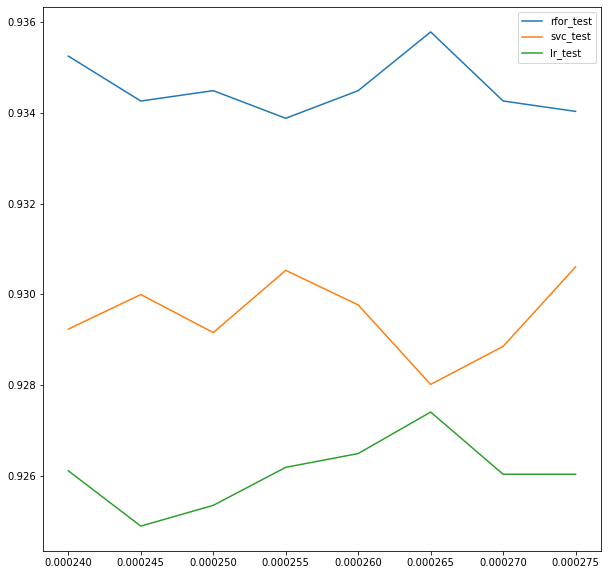

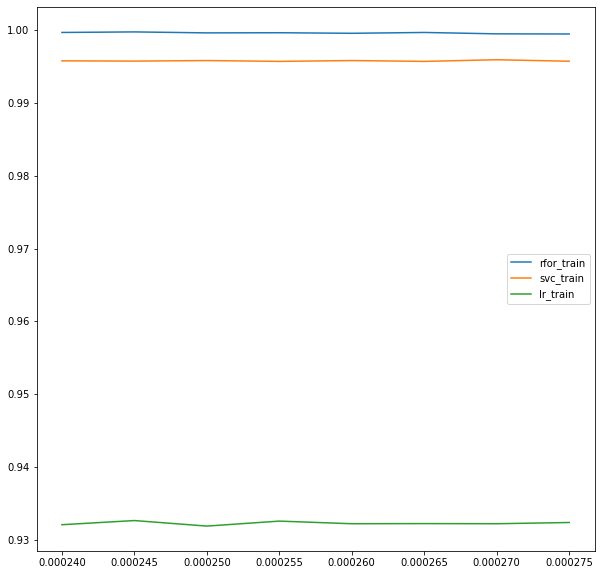

(0.9274082603996057, 0.9322021010753989)

In [148]:
#Est:50 ccp_alpha:0.000010 min_samples_split:3 accuracy test max:0.9414151661171697 accuracy train max:0.9995651701271877 
#Est:100 ccp_alpha:0.000030 min_samples_split:3 accuracy test max:0.9426832361146336 accuracy train max:0.999891292531797 
#Est:200 ccp_alpha:0.000070 min_samples_split:3 accuracy test max:0.9414151661171697 accuracy train max:0.9989129253179694 
def feature_check(alpha, n_est=50,ccp_alpha=0.00005,min_samples_split=2, C=None, kernel=None, solver=None,penalty=None):
    
    #X_train, X_test, y_train, y_test = train_test_split(df, target,random_state=0,test_size=0.3,stratify=target)
    
    results = defaultdict(lambda: [])
    
    for n in alpha:
        kf = StratifiedKFold(n_splits=5,shuffle=True)
        all_features = None

        #print("Alpha:{:.6f}".format(number_of_features))

        #make 5 fold cross valdation with use of features selected by train split

        for train_index, test_index in kf.split(df,target):
            X_train = df.iloc[train_index]
            X_train, X_test, y_train, y_test = df.iloc[train_index], df.iloc[test_index], target[train_index], target[test_index]

            #select K features with use of random forest feature selection
            #X_train_f, ft = rforest_features(X_train, y_train, n)
            X_train_f, ft = lasso(X_train, y_train, alpha=n)
            if all_features == None:
                all_features = set(ft)
            else:
                all_features = all_features.intersection(set(ft))
            #for f in ft:
            #    all_features.append(f)

            #keep only selected features in train and test splits
            X_test_f = X_test[ft]

    
            lr_model = LogisticRegression(max_iter=10000,penalty="l2",
                                                            solver="saga",C=77.9)
            lr_model.fit(X_train_f,y_train)

            results["k_lr_test"].append(accuracy_score(y_test, lr_model.predict(X_test_f)))
            results["k_lr_train"].append(accuracy_score(y_train, lr_model.predict(X_train_f)))
            
            
            #Kernel:rbf C:19 accuracy test max:0.9264951920766673 accuracy train max:0.9580352710950134 
            #Kernel:rbf C:20 accuracy test max:0.9258100000405267 accuracy train max:0.9572173665580053 
            #Kernel:rbf C:21 accuracy test max:0.9262675763191611 accuracy train max:0.9585108039737607 
            svc_model = SVC(kernel="rbf", C=19)
            svc_model.fit(X_train_f,y_train)
            results["k_svc_test"].append(accuracy_score(y_test, svc_model.predict(X_test_f)))
            results["k_svc_train"].append(accuracy_score(y_train, svc_model.predict(X_train_f)))

            #Est:50 ccp_alpha:0.000010 min_samples_split:3 accuracy test max:0.9414151661171697 accuracy train max:0.9995651701271877 
            #Est:100 ccp_alpha:0.000030 min_samples_split:3 accuracy test max:0.9426832361146336 accuracy train max:0.999891292531797 
            #Est:200 ccp_alpha:0.000070 min_samples_split:3 accuracy test max:0.9414151661171697 accuracy train max:0.9989129253179694 

            rfor_model = RandomForestClassifier(n_estimators=100,#bootstrap=False,  #best 150 - 100
                                                                criterion='gini',
                                                                ccp_alpha=0.000030, #best 0.0001 - 0.00005
                                                                min_samples_split=3) #best 2 
            rfor_model.fit(X_train_f,y_train)
            results["k_rfor_test"].append(accuracy_score(y_test, rfor_model.predict(X_test_f)))
            results["k_rfor_train"].append(accuracy_score(y_train, rfor_model.predict(X_train_f)))
            results["k_rfor_unseen"].append(accuracy_score(target_test, rfor_model.predict(df_test[ft])))
        results["lr_test"].append( sum(results["k_lr_test"]) / len(results["k_lr_test"]))
        results["lr_train"].append(sum(results["k_lr_train"])/ len(results["k_lr_train"]) )
        results["lr_unseen"].append(sum(results["k_lr_unseen"])/ len(results["k_lr_unseen"]) )
        results["k_lr_train"] = []
        results["k_lr_test"] = []
        
        results["svc_test"].append( sum(results["k_svc_test"]) / len(results["k_svc_test"]))
        results["svc_train"].append(sum(results["k_svc_train"])/ len(results["k_svc_train"]) )
        results["k_svc_train"] = []
        results["k_svc_test"] = []
        
        results["rfor_test"].append( sum(results["k_rfor_test"]) / len(results["k_rfor_test"]))
        results["rfor_train"].append(sum(results["k_rfor_train"])/ len(results["k_rfor_train"]) )
        results["k_rfor_train"] = []
        results["k_rfor_test"] = []
    
    plt.figure(figsize=(10.0,10.0))
    plt.plot(alpha, results["rfor_test"],label="rfor_test")
    plt.plot(alpha, results["svc_test"],label="svc_test")
    plt.plot(alpha, results["lr_test"],label="lr_test")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10.0,10.0))
    plt.plot(alpha, results["rfor_train"],label="rfor_train")
    plt.plot(alpha, results["svc_train"],label="svc_train")
    plt.plot(alpha, results["lr_train"],label="lr_train")
    plt.legend()
    plt.show()
    #print(results["rfor_test"])
    #print(results["rfor_train"])
    return max(results["lr_test"]), results["lr_train"][results["lr_test"].index(max(results["lr_test"]))]
#-------------------------------------
#random forest parameters fine tuning
#-------------------------------------
#for n_est in [50,100,150,200]:
#    for ccp_alpha in [0.00001, 0.00002,0.00003, 0.00004,0.00005, 0.00006,0.00007]:
#        for min_samples_split in [2,3,4]:
#            res_test, res_train = feature_check(range(30,90,5),n_est=n_est,ccp_alpha=ccp_alpha,min_samples_split =min_samples_split )
#            print("Est:{} ccp_alpha:{:.6f} min_samples_split:{} accuracy test max:{} accuracy train max:{} ".format(n_est,ccp_alpha,min_samples_split,res_test, res_train))

#---------------------------
#SVM parameters fine tuning
#---------------------------
#for kernel in ["rbf"]:
#    for c in [18,19,20,21,22]:
#        res_test, res_train = feature_check(range(30,90,5),C=c, kernel= kernel)#,n_est=n_est,ccp_alpha=ccp_alpha,min_samples_split =min_samples_split )
#        print("Kernel:{} C:{} accuracy test max:{} accuracy train max:{} ".format(kernel, c,res_test, res_train))
"""
for penalty in ['elasticnet','none']:
    for C in np.logspace(-4,4,20):
        for solver in ['lbfgs','newton-cg','liblinear','sag','saga']:
            if penalty in ['l1','elasticnet'] and solver in ['newton-cg', 'lbfgs', 'sag', 'saga']:
                continue
            if (penalty == 'elasticnet' and solver != "saga") or (penalty=='none' and solver =='liblinear'):
                continue
            #if solver in ['newton-cg', 'lbfgs', 'sag', 'saga'] and penalty in ['l2', 'none']
            res_test, res_train = feature_check(range(30,50,5),C=C, solver= solver, penalty=penalty)# kernel= kernel)#,n_est=n_est,ccp_alpha=ccp_alpha,min_samples_split 
            print("Penalty:{} C:{} solver:{} accuracy test max:{} accuracy train max:{} ".format(penalty, C, solver,res_test, res_train))
"""
#for penalty in ["l2"]:
#    for solver in ["saga"]:#"saga"]:#,"sag","liblinear"]:
#        if penalty == "l1" and solver != "liblinear":
#            continue
#        for C in np.arange(77.0,79.0,0.1):
#            res_test, res_train = feature_check(range(30,50,5),C=C, solver= solver, penalty=penalty)# kernel= kernel)#,n_est=n_est,ccp_alpha=ccp_alpha,min_samples_split 
#            print("Penalty:{} C:{} solver:{} accuracy test max:{} accuracy train max:{} ".format(penalty, C, solver,res_test, res_train))

#print("Test:",res_test)
#print("Train:",res_train)

feature_check(list(np.arange(0.00024,0.00028,0.000005)))

# Models parameter fine tuning with feature selection based on model
### - We perform the following procedure for two best models in our case (XGBoost and Random forest)

### - Since procedure take a lot of time to execute, we store some best case values in code.

### -We working on small ranges of model parameters in order to reduce execution time and find reasonable amount of time the best model parameters.


### XGBoost fine tune and feature selection

In [36]:
# ----------------------------------------------------------------#
# Very expensive in computations with all parameters
# now while i know the best parameters we need to run only 2 models comparison
# need to implement ROC plot for each model
# ----------------------------------------------------------------#
# definition of multiple parameters, we run combination of them in order to find best one

"""
#old values 
objective = ["multi:softprob"]  # ,"multi:softmax"]
learning_rate = [0.078, 0.078, 0.078, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079]
n_estimators = [430, 440, 490, 400, 400, 410, 440, 450, 450, 480, 490, 480]
max_depth = [4, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 3]
colsample_bytree = [0.35, 0.35, 0.5, 0.3, 0.45, 0.3, 0.45, 0.35, 0.45, 0.45, 0.45, 0.35]
# -----------------------------
# Model: 0 param:Obj:multi:softprob LR:0.078 N_EST:490 MAX_DEPTH:4 ByTREE:0.5 EvalTree:['aucpr']
# best 95 on 319 features
# best 94.9 on 317, 309 , 282, 260, 258, 255, 230, 198,197 , 191, 187, 179, 167, 147,
# Model: 1 param:Obj:multi:softprob LR:0.079 N_EST:400 MAX_DEPTH:4 ByTREE:0.45 EvalTree:['aucpr']
# best 94.9 on 194, 189
objective = ["multi:softprob"]
learning_rate = [0.078, 0.079]
n_estimators = [490, 400]
max_depth = [4, 4]
colsample_bytree = [0.5, 0.45]
eval_metric = ["aucpr"]


10 iterations
Model: 0 param:Obj:multi:softprob LR:0.078 N_EST:490 MAX_DEPTH:4 ByTREE:[0.5, 0.45] EvalTree:aucpr
n:319 Accuracy evaluation : 94.487 Accuracy train : 99.736
n:317 Accuracy evaluation : 94.641 Accuracy train : 99.749
n:309 Accuracy evaluation : 94.612 Accuracy train : 99.746
n:282 Accuracy evaluation : 94.610 Accuracy train : 99.749
n:260 Accuracy evaluation : 94.587 Accuracy train : 99.739
n:258 Accuracy evaluation : 94.594 Accuracy train : 99.747
n:255 Accuracy evaluation : 94.618 Accuracy train : 99.740  <- best
n:230 Accuracy evaluation : 94.597 Accuracy train : 99.721
n:198 Accuracy evaluation : 94.571 Accuracy train : 99.678
n:197 Accuracy evaluation : 94.590 Accuracy train : 99.675
n:194 Accuracy evaluation : 94.562 Accuracy train : 99.672
n:191 Accuracy evaluation : 94.619 Accuracy train : 99.665  <- best
n:189 Accuracy evaluation : 94.590 Accuracy train : 99.651
n:187 Accuracy evaluation : 94.554 Accuracy train : 99.651
n:179 Accuracy evaluation : 94.566 Accuracy train : 99.627
n:167 Accuracy evaluation : 94.584 Accuracy train : 99.595
n:147 Accuracy evaluation : 94.539 Accuracy train : 99.509
Model: 1 param:Obj:multi:softprob LR:0.079 N_EST:400 MAX_DEPTH:4 ByTREE:[0.5, 0.45] EvalTree:aucpr
n:319 Accuracy evaluation : 94.390 Accuracy train : 99.437
n:317 Accuracy evaluation : 94.523 Accuracy train : 99.430
n:309 Accuracy evaluation : 94.559 Accuracy train : 99.425
n:282 Accuracy evaluation : 94.589 Accuracy train : 99.425
n:260 Accuracy evaluation : 94.592 Accuracy train : 99.414
n:258 Accuracy evaluation : 94.620 Accuracy train : 99.423  <- best
n:255 Accuracy evaluation : 94.583 Accuracy train : 99.424
n:230 Accuracy evaluation : 94.570 Accuracy train : 99.397
n:198 Accuracy evaluation : 94.566 Accuracy train : 99.325
n:197 Accuracy evaluation : 94.537 Accuracy train : 99.321
n:194 Accuracy evaluation : 94.561 Accuracy train : 99.314
n:191 Accuracy evaluation : 94.567 Accuracy train : 99.312
n:189 Accuracy evaluation : 94.563 Accuracy train : 99.303
n:187 Accuracy evaluation : 94.577 Accuracy train : 99.289
n:179 Accuracy evaluation : 94.571 Accuracy train : 99.251
n:167 Accuracy evaluation : 94.557 Accuracy train : 99.201
n:147 Accuracy evaluation : 94.527 Accuracy train : 99.085
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
20 iterations 
Model: 0 param:Obj:multi:softprob LR:0.078 N_EST:490 MAX_DEPTH:4 ByTREE:[0.5, 0.45] EvalTree:aucpr
n:258 Accuracy evaluation : 94.567 Accuracy train : 99.747
n:255 Accuracy evaluation : 94.575 Accuracy train : 99.746
n:191 Accuracy evaluation : 94.584 Accuracy train : 99.653
Model: 1 param:Obj:multi:softprob LR:0.079 N_EST:400 MAX_DEPTH:4 ByTREE:[0.5, 0.45] EvalTree:aucpr
n:258 Accuracy evaluation : 94.574 Accuracy train : 99.429
n:255 Accuracy evaluation : 94.559 Accuracy train : 99.432
n:191 Accuracy evaluation : 94.594 Accuracy train : 99.293
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
Model: 0 param:Obj:multi:softprob LR:0.078 N_EST:490 MAX_DEPTH:4 ByTREE:[0.5, 0.45] EvalTree:aucpr
n:307 Accuracy evaluation : 94.682 Accuracy train : 99.735
n:206 Accuracy evaluation : 94.661 Accuracy train : 99.687
Model: 1 param:Obj:multi:softprob LR:0.079 N_EST:400 MAX_DEPTH:4 ByTREE:[0.5, 0.45] EvalTree:aucpr
n:239 Accuracy evaluation : 94.665 Accuracy train : 99.418
n:241 Accuracy evaluation : 94.700 Accuracy train : 99.434
n:235 Accuracy evaluation : 94.674 Accuracy train : 99.413
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
Model: 0 param:Obj:multi:softprob LR:0.078 N_EST:490 MAX_DEPTH:4 ByTREE:[0.5, 0.45] EvalTree:aucpr
n:307 Accuracy evaluation : 94.659 Accuracy train : 99.775
n:206 Accuracy evaluation : 94.668 Accuracy train : 99.704
Model: 1 param:Obj:multi:softprob LR:0.079 N_EST:400 MAX_DEPTH:4 ByTREE:[0.5, 0.45] EvalTree:aucpr
n:241 Accuracy evaluation : 94.653 Accuracy train : 99.442
n:239 Accuracy evaluation : 94.624 Accuracy train : 99.436
n:235 Accuracy evaluation : 94.633 Accuracy train : 99.430
"""

#store model paramters for printing reason.
#Used in order to identify model parameters and resulting values
model_param = []
#list of ech model scores (test, train)
model_scores = []
#fill model params and scores
for i in range(len(colsample_bytree)):
    model_scores.append(defaultdict(lambda: {"test": [], "train": []}))
    model_param.append("Obj:{} LR:{} N_EST:{} MAX_DEPTH:{} ByTREE:{} EvalTree:{}".format(
        objective[0], learning_rate[i], n_estimators[i], max_depth[i], colsample_bytree, eval_metric[0]))

#internal counter of computer iterations 
c = 0
#define file name of csv dataset
filename = "../data/features_large_with_words.csv"
#define number of iterations
number_of_iter = 10

#define number of features that used in computations 
features = [206,235,241,307]

#starting time of computations, used in order to compute remaining time.
start_time = datetime.now()

#compute number of computations that should be executed, used for computation of remaining time and computations.
all_comp = len(model_scores) * number_of_iter * 5

# iterate on data with multiple monte-carlo folds 
# at each we re-read data and shuffle them in random order
# after split the shuffled data into train/evaluation and test
# train/evaluation are used by k-fold in order to train model and get accuracy.
# Since we utilize only train/evaluation data portion, we scale those data and perform oversample of them in order to balance classes
# Test portion of data are not used in multiple folds, this data portion are used at the end of process when we have single model
# Test data are not oversampled, we only scale them in order to have similar vector values.
for fold in range(number_of_iter):
    # split entire dataset into 2 parts:
    #                    1st with all data used in training/evaluation(80%)
    #                    2nd with data used in final testing (20%)
    df, target, df_test, target_test = read_data(filename, verbose=True)

    #define kfold
    kf = StratifiedKFold(n_splits=5, shuffle=True)

    for train_index, test_index in kf.split(df, target):
        #train_index and test_index provide indexes of df that shoud be used 
        #in order to select train ant evaluation portions
        X_train, X_eval = df.iloc[train_index], df.iloc[test_index]
        y_train, y_eval = target.iloc[train_index], target.iloc[test_index]

        # scale data separatly
        X_train, X_eval, df_test_scaled = scale_data(X_train, X_eval, df_test)

        # oversamplong clean on training set
        X_train, y_train = oversample(X_train, y_train)
        # oversampling clean on evaluation set
        X_eval, y_eval = oversample(X_eval, y_eval)

        #for each k-fold folds select our model parameters in iterative way
        for i in range(len(colsample_bytree)):
            obj = objective[0]
            lr = learning_rate[i]
            n_est = n_estimators[i]
            mx_d = max_depth[i]
            col_b = colsample_bytree[i]
            ev_metric = eval_metric[0]

            #train model with all features in order to select N best features based in training set 
            model = XGBClassifier(objective=obj,
                                  num_class=2,
                                  learning_rate=lr,
                                  n_estimators=n_est,
                                  max_depth=mx_d,
                                  colsample_bytree=col_b,
                                  eval_metric=ev_metric,  # "rmse",
                                  use_label_encoder=False)

            model.fit(X_train, y_train)

            #case of 2 last models when we know best range of features, select only them
            #for t in thresholds:
            #if i == 0:
            #    features = [307,206]
            #else:
            #    features = [235,239,241]
            
            #train and evaluate model for all features range starting from 2 till end,
            # by growing number of top features
            for n in features:
                # select N top features from pre-trained model
                selection = SelectFromModel(model, threshold=-np.inf, max_features=n,prefit=True)
                
                #transform datasets based on selected features
                select_X_train = selection.transform(X_train)
                select_X_eval = selection.transform(X_eval)
                
                #print("N:{}, Shape:{}".format(n, select_X_train.shape))
                
                #if np.sum(selection.get_support()) not in [191,255,258]:
                #    continue
                #print(df.columns[selection.get_support()])
                #break
                
                #Create and train new model that know onyl those N features
                selection_model = XGBClassifier(objective=obj,
                                                num_class=2,
                                                learning_rate=lr,
                                                n_estimators=n_est,
                                                max_depth=mx_d,
                                                colsample_bytree=col_b,
                                                eval_metric=ev_metric,  # "rmse",
                                                use_label_encoder=False)
                selection_model.fit(select_X_train, y_train)
                
                # evaluate model, by calculating acuracy of train and evalutation data portion
                accuracy_eval = accuracy_score(y_eval, selection_model.predict(select_X_eval))
                accuracy_train = accuracy_score(y_train, selection_model.predict(select_X_train))
                
                #store acuracy values in model_scores list
                #          I: present model number
                #          select_X_train.shape[1] is same with N : show number of selected features
                model_scores[i][select_X_train.shape[1]]["test"].append(accuracy_eval * 100.0)
                model_scores[i][select_X_train.shape[1]]["train"].append(accuracy_train * 100.0)
            
            #increase count value since we finish with single iteration of k-fold of particular model
            c += 1

            #calculate time that is spend till now in minutes
            spend_time = (datetime.now() - start_time).seconds / 60.0
            #print time that was spend, number of comutation left and time that is left till the end
            print("Time spend:{} min. left comp: {} left time:{}".format(spend_time, all_comp - c,
                                                                 (spend_time / c) * (all_comp - c)))


#for each model in our experiment print parameters of model and for each number of features 
# print accuracy of evaluation and train (AVERAGE values)
for i in range(len(model_scores)):
    print("Model: {} param:{}".format(i, model_param[i]))
    n = list(model_scores[i].keys())
    n.sort(reverse=True)
    for sc in n:
        print("n:{} Accuracy evaluation : {:.3f} Accuracy train : {:.3f}"
              .format(sc,
                      sum(model_scores[i][sc]["test"]) / len(model_scores[i][sc]["test"]),
                      sum(model_scores[i][sc]["train"]) / len(model_scores[i][sc]["train"]),))                      ))




N:307, Shape:(9190, 307)
N:206, Shape:(9190, 206)
Time spend:1.3833333333333333 min. left comp: 99 left time:136.95
N:235, Shape:(9190, 235)
N:239, Shape:(9190, 239)
N:241, Shape:(9190, 241)
Time spend:1.95 min. left comp: 98 left time:95.55
N:307, Shape:(9198, 307)
N:206, Shape:(9198, 206)
Time spend:3.2666666666666666 min. left comp: 97 left time:105.62222222222222
N:235, Shape:(9198, 235)
N:239, Shape:(9198, 239)
N:241, Shape:(9198, 241)
Time spend:3.8 min. left comp: 96 left time:91.19999999999999
N:307, Shape:(9222, 307)
N:206, Shape:(9222, 206)
Time spend:5.133333333333334 min. left comp: 95 left time:97.53333333333335
N:235, Shape:(9222, 235)
N:239, Shape:(9222, 239)
N:241, Shape:(9222, 241)
Time spend:5.666666666666667 min. left comp: 94 left time:88.77777777777779
N:307, Shape:(9220, 307)
N:206, Shape:(9220, 206)
Time spend:7.05 min. left comp: 93 left time:93.66428571428571
N:235, Shape:(9220, 235)
N:239, Shape:(9220, 239)
N:241, Shape:(9220, 241)
Time spend:7.583333333333333

N:307, Shape:(9216, 307)
N:206, Shape:(9216, 206)
Time spend:63.583333333333336 min. left comp: 37 left time:37.342592592592595
N:235, Shape:(9216, 235)
N:239, Shape:(9216, 239)
N:241, Shape:(9216, 241)
Time spend:64.15 min. left comp: 36 left time:36.084375
N:307, Shape:(9222, 307)
N:206, Shape:(9222, 206)
Time spend:65.63333333333334 min. left comp: 35 left time:35.341025641025645
N:235, Shape:(9222, 235)
N:239, Shape:(9222, 239)
N:241, Shape:(9222, 241)
Time spend:66.2 min. left comp: 34 left time:34.10303030303031
N:307, Shape:(9212, 307)
N:206, Shape:(9212, 206)
Time spend:67.56666666666666 min. left comp: 33 left time:33.27910447761194
N:235, Shape:(9212, 235)
N:239, Shape:(9212, 239)
N:241, Shape:(9212, 241)
Time spend:68.15 min. left comp: 32 left time:32.07058823529412
N:307, Shape:(9210, 307)
N:206, Shape:(9210, 206)
Time spend:69.56666666666666 min. left comp: 31 left time:31.254589371980675
N:235, Shape:(9210, 235)
N:239, Shape:(9210, 239)
N:241, Shape:(9210, 241)
Time spen

### RandomForest fine tune and feature selection

In [27]:
"""
#Est:50 ccp_alpha:0.000010 min_samples_split:3 accuracy test max:0.9414151661171697 accuracy train max:0.9995651701271877 
#Est:100 ccp_alpha:0.000030 min_samples_split:3 accuracy test max:0.9426832361146336 accuracy train max:0.999891292531797 
#Est:200 ccp_alpha:0.000070 min_samples_split:3 accuracy test max:0.9414151661171697 accuracy train max:0.9989129253179694 
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
n_estimators=[50,100,150,200]
ccp_alpha =list(np.arange(0.00001,0.00008,0.00001))
min_samples_split=[2,3,4]
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
n_estimators = [200,200,200,100, 100,100,150,150,150,150,200]
ccp_alpha = [0.00003,0.00005,0.00007,0.00001,0.00002,0.00003,0.00002,0.00005,0.00006,0.00007,0.00003]
min_samples_split = [3,4,2,3,3,2,3,3,2,2,3]
#Model: 70 param:N_estim:200 CC_alpha:3.0000000000000004e-05 Min_sample_split:3
#Model: 77 param:N_estim:200 CC_alpha:5e-05 Min_sample_split:4
#Model: 81 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:2
#Model: 22 param:N_estim:100 CC_alpha:1e-05 Min_sample_split:3
#Model: 25 param:N_estim:100 CC_alpha:2e-05 Min_sample_split:3
#Model: 27 param:N_estim:100 CC_alpha:3.0000000000000004e-05 Min_sample_split:2
#Model: 46 param:N_estim:150 CC_alpha:2e-05 Min_sample_split:3
#Model: 55 param:N_estim:150 CC_alpha:5e-05 Min_sample_split:3
#Model: 57 param:N_estim:150 CC_alpha:6e-05 Min_sample_split:2
#Model: 60 param:N_estim:150 CC_alpha:7.000000000000001e-05 Min_sample_split:2
#Model: 70 param:N_estim:200 CC_alpha:3.0000000000000004e-05 Min_sample_split:3
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
#n_estimators=[50]
#ccp_alpha =[0.00001]
#min_samples_split=[3]
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
#best 11 model with all features has best ones in :
#Model: 0 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:4
#n:193 Accuracy evaluation : 93.515 Accuracy train : 99.976
#Model: 1 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:4
#n:144 Accuracy evaluation : 93.524
#n:135 Accuracy evaluation : 93.524 Accuracy train : 99.650
#Model: 4 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:4
#n:177 Accuracy evaluation : 93.506 Accuracy train : 99.954
#Model: 9 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:4
#n:253 Accuracy evaluation : 93.541 Accuracy train : 99.937
#n:126 Accuracy evaluation : 93.532 Accuracy train : 99.967
#n:69 Accuracy evaluation : 93.524 Accuracy train : 99.939
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
n_estimators = [50,50,50,100,100,100,100,150,200,200,200, 100,150]
ccp_alpha = [0.00001,0.00005,0.00006,0.00001,0.00005,0.00007,0.00009,0.00007,0.00005,0.00003,0.00005,0.00002,0.00007]
min_samples_split = [3,4,4,4,4,3,2,3,2,3,4,3,2]
features = [185,277,146,81,162,169,302,312,292,132,193,69]
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
n_estimators = [200,200, 100,150]
ccp_alpha = [0.00003,0.00005,0.00002,0.00007]
min_samples_split = [3,4,3,2]
#for those models we have :
Model: 0 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:4
n:253 Accuracy evaluation : 93.338 Accuracy train : 99.970
n:193 Accuracy evaluation : 93.411 Accuracy train : 99.963   <-best
n:177 Accuracy evaluation : 93.373 Accuracy train : 99.960
n:144 Accuracy evaluation : 93.364 Accuracy train : 99.952
n:135 Accuracy evaluation : 93.318 Accuracy train : 99.971
n:126 Accuracy evaluation : 93.353 Accuracy train : 99.968
n:69 Accuracy evaluation : 93.309 Accuracy train : 99.957
Model: 1 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:4
n:253 Accuracy evaluation : 93.329 Accuracy train : 99.588
n:193 Accuracy evaluation : 93.350 Accuracy train : 99.578
n:177 Accuracy evaluation : 93.347 Accuracy train : 99.574
n:144 Accuracy evaluation : 93.367 Accuracy train : 99.592
n:135 Accuracy evaluation : 93.344 Accuracy train : 99.610
n:126 Accuracy evaluation : 93.347 Accuracy train : 99.595
n:69 Accuracy evaluation : 93.344 Accuracy train : 99.595
Model: 2 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:4
n:253 Accuracy evaluation : 93.344 Accuracy train : 99.944
n:193 Accuracy evaluation : 93.376 Accuracy train : 99.940
n:177 Accuracy evaluation : 93.268 Accuracy train : 99.930
n:144 Accuracy evaluation : 93.295 Accuracy train : 99.933
n:135 Accuracy evaluation : 93.330 Accuracy train : 99.943
n:126 Accuracy evaluation : 93.330 Accuracy train : 99.947
n:69 Accuracy evaluation : 93.309 Accuracy train : 99.941
Model: 3 param:N_estim:200 CC_alpha:7.000000000000001e-05 Min_sample_split:4
n:253 Accuracy evaluation : 93.350 Accuracy train : 99.952
n:193 Accuracy evaluation : 93.329 Accuracy train : 99.950
n:177 Accuracy evaluation : 93.350 Accuracy train : 99.955
n:144 Accuracy evaluation : 93.312 Accuracy train : 99.952
n:135 Accuracy evaluation : 93.292 Accuracy train : 99.954
n:126 Accuracy evaluation : 93.373 Accuracy train : 99.946
n:69 Accuracy evaluation : 93.434 Accuracy train : 99.952   <-best
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
#run more that 10 fold iterations for kfold validation for features 69, 193
n_estimators = [200,150]
ccp_alpha = [0.00003,0.00007]
min_samples_split = [3,2]
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
Model: 1 param:N_estim:50 CC_alpha:1e-05 Min_sample_split:3
n:185 Accuracy evaluation : 94.103 Accuracy train : 99.887

Model: 14 param:N_estim:50 CC_alpha:5e-05 Min_sample_split:4
n:277 Accuracy evaluation : 94.131 Accuracy train : 99.587

Model: 17 param:N_estim:50 CC_alpha:6e-05 Min_sample_split:4
n:146 Accuracy evaluation : 94.103 Accuracy train : 99.500

Model: 29 param:N_estim:100 CC_alpha:1e-05 Min_sample_split:4
n:81 Accuracy evaluation : 94.103 Accuracy train : 99.775

Model: 41 param:N_estim:100 CC_alpha:5e-05 Min_sample_split:4
n:162 Accuracy evaluation : 94.103 Accuracy train : 99.587

Model: 46 param:N_estim:100 CC_alpha:7.000000000000001e-05 Min_sample_split:3
n:169 Accuracy evaluation : 94.103 Accuracy train : 99.862

Model: 51 param:N_estim:100 CC_alpha:9e-05 Min_sample_split:2
n:302 Accuracy evaluation : 94.160 Accuracy train : 99.875

Model: 65 param:N_estim:150 CC_alpha:4e-05 Min_sample_split:4
n:312 Accuracy evaluation : 94.103 Accuracy train : 99.737

Model: 73 param:N_estim:150 CC_alpha:7.000000000000001e-05 Min_sample_split:3
n:292 Accuracy evaluation : 94.131 Accuracy train : 99.800

Model: 93 param:N_estim:200 CC_alpha:5e-05 Min_sample_split:2
n:132 Accuracy evaluation : 94.131 Accuracy train : 100.000
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
n_estimators = [50,50,50,100,100,100,100,150,200,200,200, 100,150]
ccp_alpha = [0.00001,0.00005,0.00006,0.00001,0.00005,0.00007,0.00009,0.00007,0.00005,0.00003,0.00005,0.00002,0.00007]
min_samples_split = [3,4,4,4,4,3,2,3,2,3,4,3,2]
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
Model: 1 param:N_estim:200 CC_alpha:5e-05 Min_sample_split:4

n:99 Accuracy evaluation : 93.510 Accuracy train : 99.811
n:98 Accuracy evaluation : 93.506 Accuracy train : 99.807
n:97 Accuracy evaluation : 93.507 Accuracy train : 99.811
n:96 Accuracy evaluation : 93.517 Accuracy train : 99.803
n:95 Accuracy evaluation : 93.513 Accuracy train : 99.796
n:94 Accuracy evaluation : 93.500 Accuracy train : 99.810
n:93 Accuracy evaluation : 93.501 Accuracy train : 99.802
n:91 Accuracy evaluation : 93.492 Accuracy train : 99.794
n:90 Accuracy evaluation : 93.515 Accuracy train : 99.794
n:89 Accuracy evaluation : 93.503 Accuracy train : 99.791
n:88 Accuracy evaluation : 93.486 Accuracy train : 99.793
n:87 Accuracy evaluation : 93.508 Accuracy train : 99.792
n:85 Accuracy evaluation : 93.505 Accuracy train : 99.785
n:82 Accuracy evaluation : 93.502 Accuracy train : 99.773 

Model: 2 param:N_estim:150 CC_alpha:7e-05 Min_sample_split:2

n:99 Accuracy evaluation : 93.496 Accuracy train : 99.991
n:98 Accuracy evaluation : 93.515 Accuracy train : 99.990
n:97 Accuracy evaluation : 93.510 Accuracy train : 99.991

n:95 Accuracy evaluation : 93.514 Accuracy train : 99.992
n:94 Accuracy evaluation : 93.481 Accuracy train : 99.992
n:93 Accuracy evaluation : 93.483 Accuracy train : 99.993
n:92 Accuracy evaluation : 93.493 Accuracy train : 99.992
n:91 Accuracy evaluation : 93.520 Accuracy train : 99.990

n:89 Accuracy evaluation : 93.508 Accuracy train : 99.992

n:87 Accuracy evaluation : 93.481 Accuracy train : 99.991
n:86 Accuracy evaluation : 93.488 Accuracy train : 99.990

n:84 Accuracy evaluation : 93.488 Accuracy train : 99.991
n:83 Accuracy evaluation : 93.503 Accuracy train : 99.990

n:81 Accuracy evaluation : 93.502 Accuracy train : 99.989
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
features = [185,277,146,81,162,169,302,312,292,132,193,69]
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
#BEST model and features based on 5 iterations:
#Model: 3 param:N_estim:100 CC_alpha:1e-05 Min_sample_split:4
#n:81 Accuracy evaluation : 93.344 Accuracy train : 99.675  <- best
#Model: 10 param:N_estim:200 CC_alpha:5e-05 Min_sample_split:4
#n:193 Accuracy evaluation : 93.336 Accuracy train : 99.577  <- best 
#n:169 Accuracy evaluation : 93.356 Accuracy train : 99.590  <- best
#Model: 12 param:N_estim:150 CC_alpha:7e-05 Min_sample_split:2
#n:302 Accuracy evaluation : 93.344 Accuracy train : 99.952  <- best
#n:193 Accuracy evaluation : 93.330 Accuracy train : 99.952  <- best
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
n_estimators = [100,200,150]
ccp_alpha = [0.00001,0.00005,0.00007]
min_samples_split = [4,4,2]

features = [81,169,193,302]
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
n_estimators = [150]
ccp_alpha = [0.00007]
min_samples_split = [2]

features = [81,169,193,302]

n:134 Accuracy evaluation : 93.529 Accuracy train : 99.996
n:132 Accuracy evaluation : 93.543 Accuracy train : 99.993
n:105 Accuracy evaluation : 93.538 Accuracy train : 99.993
n:102 Accuracy evaluation : 93.524 Accuracy train : 99.996
n:101 Accuracy evaluation : 93.524 Accuracy train : 99.995
n:90 Accuracy evaluation : 93.536 Accuracy train : 99.994
#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
features = [90,101,102,105,132,134]
Model: 0 param:N_estim:150 CC_alpha:7e-05 Min_sample_split:2
n:134 Accuracy evaluation : 93.355 Accuracy train : 99.991
n:132 Accuracy evaluation : 93.405 Accuracy train : 99.992
n:105 Accuracy evaluation : 93.421 Accuracy train : 99.992
n:102 Accuracy evaluation : 93.429 Accuracy train : 99.994 <- best with 20 iterations of 5-fold cross validation
n:101 Accuracy evaluation : 93.412 Accuracy train : 99.992
n:90 Accuracy evaluation : 93.404 Accuracy train : 99.991
"""
#features.sort()

model_param = []
model_scores = []
#for n_est in n_estimators:
#    for c_alpha in ccp_alpha:
#        for min_sam in min_samples_split:
#            model_scores.append(defaultdict(lambda: {"test": [], "train": []}))
#            model_param.append("N_estim:{} CC_alpha:{} Min_sample_split:{}".format(
#                                    n_est, c_alpha, min_sam))
for i in range(len(min_samples_split)):
    model_scores.append(defaultdict(lambda: {"test": [], "train": []}))
    model_param.append("N_estim:{} CC_alpha:{} Min_sample_split:{}".format(
                                    n_estimators[i], 
                                    ccp_alpha[i], 
                                    min_samples_split[i]))

c = 0

filename = "../data/features_large_with_words.csv"
number_of_iter = 20 
start_time = datetime.now()
all_comp = len(model_scores) * number_of_iter * 5
for fold in range(number_of_iter):
    #split entire dataset into 2 parts: 
    #                    1st with all data used in training/evaluation(80%) 
    #                    2nd with data used in final testing (20%) 
    df, target, df_test, target_test = read_data(filename, verbose=True)
    
    models = []
    predictions = []
    accuracy = []
    
    start_time = datetime.now()
    #all_comp = len(objective) * len(learning_rate) * len(n_estimators) * len(max_depth) * len(colsample_bytree)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    #all_features = None

    # print("Alpha:{:.6f}".format(number_of_features))
    
    #at this step we use only 1st splited part with 80% of our data that is used on train/eval split (70/30)
    #X_train, X_eval, y_train, y_eval = train_test_split(df, target, test_size=0.3)

    
    for train_index, test_index in kf.split(df, target):
        #i = 0
        X_train, X_eval = df.iloc[train_index], df.iloc[test_index]
        y_train, y_eval = target.iloc[train_index], target.iloc[test_index]

        # scale data separatly
        X_train, X_eval, df_test_scaled = scale_data(X_train, X_eval, df_test)

        # oversamplong clean on training set
        X_train, y_train = oversample(X_train, y_train)
        #oversampling clean on evaluation set
        X_eval, y_eval = oversample(X_eval, y_eval)
        #for n_est in n_estimators:
        #    for c_alpha in ccp_alpha:
        #        for min_sam in min_samples_split:

        for i in range(len(min_samples_split)):
            scores = defaultdict(lambda: {"test": [], "train": [], "unseen": []})

            #for n in list(range(1,5)) + list(range(int(X_train.shape[1]/2),int(X_train.shape[1]/2) + 5)) + list(range(X_train.shape[1] - 5 ,X_train.shape[1])):
            #for n in range(1,X_train.shape[1]):
            model = RandomForestClassifier(n_estimators=n_estimators[i],
                                            criterion='gini',
                                            ccp_alpha=ccp_alpha[i], #best 0.0001 - 0.00005
                                            min_samples_split=min_samples_split[i]) #best 
            model.fit(X_train,y_train)
            
            
            for n in features:

                # select features using threshold
                #X_train_f, ft = rforest_features(X_train, y_train, n)
                #X_eval_f = X_eval[ft]
                #print("Features:{}".format(n))
                

            
                selection = SelectFromModel(model, threshold=-np.inf, max_features=n,prefit=True)
                X_train_f = selection.transform(X_train)
                X_eval_f = selection.transform(X_eval)
                #print("Shape:{}".format(X_train_f.shape[1]))

                # train model
                selection_model = RandomForestClassifier(n_estimators=n_estimators[i],
                                            criterion='gini',
                                            ccp_alpha=ccp_alpha[i], #best 0.0001 - 0.00005
                                            min_samples_split=min_samples_split[i]) #best 

                selection_model.fit(X_train_f, y_train)
                # eval model

                predictions = selection_model.predict(X_eval_f)
                accuracy = accuracy_score(y_eval, predictions)

                predictions_train = selection_model.predict(X_train_f)
                accuracy_train = accuracy_score(y_train, predictions_train)
                """
                select_df_test = selection.transform(df_test)
                predictions_df_test = selection_model.predict(select_df_test)
                accuracy_df_test = accuracy_score(target_test, predictions_df_test)
                """
                #print(i)
                #print(model_scores[i])
                #print(n)
                #print(model_scores[i][n])
                #print("-----------------")

                model_scores[i][X_train_f.shape[1]]["test"].append(accuracy*100.0)
                model_scores[i][X_train_f.shape[1]]["train"].append(accuracy_train*100.0)
            c += 1
            #i += 1

            spend_time = (datetime.now() - start_time).seconds / 60.0
            print("Time spend:{} min. left comp: {} left time:{}".format(spend_time, all_comp - c,
                                                                 (spend_time / c) * (all_comp - c)))


for i in range(len(model_scores)):
    print("Model: {} param:{}".format(i, model_param[i]))
    n = list(model_scores[i].keys())
    n.sort(reverse=True)
    for sc in n:
        print("n:{} Accuracy evaluation : {:.3f} Accuracy train : {:.3f}"
                        #+"Accuracy df test : {:.3f}"
                        .format(sc,
                             sum(model_scores[i][sc]["test"])/len(model_scores[i][sc]["test"]),
                             sum(model_scores[i][sc]["train"])/len(model_scores[i][sc]["train"]),
                             #sum(model_scores[sc]["unseen"])/len(model_scores[sc]["unseen"])
                             ))




Time spend:1.5666666666666667 min. left comp: 99 left time:155.1
Time spend:3.15 min. left comp: 98 left time:154.35
Time spend:4.7 min. left comp: 97 left time:151.96666666666667
Time spend:6.266666666666667 min. left comp: 96 left time:150.4
Time spend:7.816666666666666 min. left comp: 95 left time:148.51666666666665
Time spend:1.65 min. left comp: 94 left time:25.849999999999998
Time spend:3.316666666666667 min. left comp: 93 left time:44.06428571428572
Time spend:4.966666666666667 min. left comp: 92 left time:57.11666666666667
Time spend:6.683333333333334 min. left comp: 91 left time:67.57592592592593
Time spend:8.35 min. left comp: 90 left time:75.14999999999999
Time spend:1.5833333333333333 min. left comp: 89 left time:12.810606060606059
Time spend:3.183333333333333 min. left comp: 88 left time:23.344444444444445
Time spend:4.816666666666666 min. left comp: 87 left time:32.23461538461538
Time spend:6.45 min. left comp: 86 left time:39.621428571428574
Time spend:8.0 min. left comp

## Random Forest (after fine tuning) 5 fold cross validation with testing portion of data accuracy 

In [ ]:

n_estimators = 150
ccp_alpha = 0.00007
min_samples_split = 2

#features.sort()



model_scores = {"test": [], "train": [], "unseen":[]}

c = 0

filename = "../data/features_large_with_words.csv"
number_of_iter = 20 
start_time = datetime.now()
all_comp = number_of_iter * 5

start_time = datetime.now()
#Make multiple folds of data

for fold in range(number_of_iter):
    #split entire dataset into 2 parts: 
    #                    1st (80%) with all data used in training/evaluation
    #                    2nd (20%) with data used in final testing
    #Each time when we read file, we random shufle it
    df, target, df_test, target_test = read_data(filename, verbose=True)
    
    #df , target is 80% of dataset from file
    #df_test, target_test is 20% of dataset used only for evalution
    
    
    #all_comp = len(objective) * len(learning_rate) * len(n_estimators) * len(max_depth) * len(colsample_bytree)
    
    ##############################
    #Make 5 Fold cross validation#
    ##############################
    
    #Split the df and target by 70/30 for train and validation, in stratified form 
    #X_train, X_val, y_train, y_val = train_test_split(df, target, test_size=0.30,stratify=target)
    
    #Make Stratified K-Fold cross validation of K=5 with random shufle 
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for train_index, test_index in kf.split(df, target):
        #i = 0
        X_train, X_val = df.iloc[train_index], df.iloc[test_index]
        y_train, y_val = target.iloc[train_index], target.iloc[test_index]

        ##############################################
        #Scale data (train,evaluation and final test)#
        ##############################################

        # scale train,evaluation and final testing data 
        X_train, X_val, Final_X = scale_data(X_train, X_val, df_test)

        ####################################################
        #Oversample train and validation portion separately#
        ####################################################

        # oversampling clean on training set
        X_train, y_train = oversample(X_train, y_train)


        #oversampling clean on validation set
        X_val, y_val = oversample(X_val, y_val)

        ####################################################
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
        #Important, we do not oversample the final test set#
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
        ####################################################

        ############################################
        #Train model based on train portion of data#
        #This model used for feature selection.    #
        ############################################

        model = RandomForestClassifier(n_estimators=n_estimators,
                                        criterion='gini',
                                        ccp_alpha=ccp_alpha, #best 0.0001 - 0.00005
                                        min_samples_split=min_samples_split) #best 
        model.fit(X_train,y_train)

        #########################################################
        #Select from trained model the N most important features#
        #########################################################

        selection = SelectFromModel(model, threshold=-np.inf, max_features=102,prefit=True)

        ######################################################################################
        #Based on those selected features, transform the train,validation and final test sets#
        ######################################################################################

        X_train_f = selection.transform(X_train)
        X_val_f = selection.transform(X_val)
        Final_X = selection.transform(Final_X)

        ########################################################################
        #Train model based on train portion of data with selected features only#
        ########################################################################

        selection_model = RandomForestClassifier(n_estimators=n_estimators,
                                    criterion='gini',
                                    ccp_alpha=ccp_alpha, #best 0.0001 - 0.00005
                                    min_samples_split=min_samples_split) #best 

        selection_model.fit(X_train_f, y_train)

        ################################################
        #Evaluation of model by pretiction of val data#
        ################################################

        #predict train labels
        predictions_train = selection_model.predict(X_train_f)

        #predict validation labels
        predictions = selection_model.predict(X_val_f)

        #predict the final test labels
        predictions_final = selection_model.predict(Final_X)


        #########################
        #Compute accuracy scores#
        #########################

        accuracy_train = accuracy_score(y_train, predictions_train)
        accuracy = accuracy_score(y_val, predictions)
        accuracy_df_test = accuracy_score(target_test, predictions_final)

        ########################################
        #Score model scores for particular fold#
        ########################################

        model_scores["test"].append(accuracy*100.0)
        model_scores["train"].append(accuracy_train*100.0)
        model_scores["unseen"].append(accuracy_df_test*100.0)
        
        c += 1 
        spend_time = (datetime.now() - start_time).seconds / 60.0
        print("Time spend:{} min. left comp: {} left time:{}".format(spend_time, all_comp - c,
                                                                 (spend_time / c) * (all_comp - c)))


print("Random forest: Accuracy validation : {:.3f} Accuracy train : {:.3f} Accuracy test : {:.3f}"
                            .format(
                             sum(model_scores["test"])/len(model_scores["test"]),
                             sum(model_scores["train"])/len(model_scores["train"]),
                             sum(model_scores["unseen"])/len(model_scores["unseen"]),
                             ))




Time spend:1.0833333333333333 min. left comp: 99 left time:107.24999999999999
Time spend:2.183333333333333 min. left comp: 98 left time:106.98333333333332
Time spend:3.3666666666666667 min. left comp: 97 left time:108.85555555555555
Time spend:4.566666666666666 min. left comp: 96 left time:109.6
Time spend:5.766666666666667 min. left comp: 95 left time:109.56666666666666
Time spend:6.883333333333334 min. left comp: 94 left time:107.8388888888889
Time spend:7.966666666666667 min. left comp: 93 left time:105.84285714285714
Time spend:9.083333333333334 min. left comp: 92 left time:104.45833333333334
Time spend:10.233333333333333 min. left comp: 91 left time:103.47037037037035
Time spend:11.35 min. left comp: 90 left time:102.15
Time spend:12.483333333333333 min. left comp: 89 left time:101.00151515151515
Time spend:13.583333333333334 min. left comp: 88 left time:99.61111111111111
Time spend:14.566666666666666 min. left comp: 87 left time:97.48461538461538
Time spend:15.65 min. left comp: 

## XGBoost (after fine tuning) 5 fold cross validation with testing portion of data accuracy 

In [37]:

n_estimators = 150
ccp_alpha = 0.00007
min_samples_split = 2

#features.sort()

objective = "multi:softprob"
learning_rate = 0.078
n_estimators = 490
max_depth = 4
colsample_bytree = 0.5
eval_metric = "aucpr"

model_scores = {"test": [], "train": [], "unseen":[]}

c = 0

filename = "../data/features_large_with_words.csv"
number_of_iter = 20 
start_time = datetime.now()
all_comp = number_of_iter
start_time = datetime.now()

#Make multiple folds of data
for fold in range(number_of_iter):
    #split entire dataset into 2 parts: 
    #                    1st(80%) with all data used in training/validation
    #                    2nd(20%) with data used in final testing (20%) 
    #Each time when we read file, we random shufle it
    
    #df , target is 80% of dataset from file
    #df_test, target_test is 20% of dataset used only for evalution
    df, target, df_test, target_test = read_data(filename, verbose=True)
    
    
   
    #X_train, X_eval, y_train, y_eval = train_test_split(df, target, test_size=0.30,stratify=target)
    
    ##############################
    #Make 5 Fold cross validation#
    ##############################
    
    #Split the df and target by 70/30 for train and validation, in stratified form 
    #X_train, X_val, y_train, y_val = train_test_split(df, target, test_size=0.30,stratify=target)
    
    #Make Stratified K-Fold cross validation of K=5 with random shufle 
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for train_index, test_index in kf.split(df, target):
        #i = 0
        X_train, X_val = df.iloc[train_index], df.iloc[test_index]
        y_train, y_val = target.iloc[train_index], target.iloc[test_index]
        
        ##############################################
        #Scale data (train,evaluation and final test)#
        ##############################################

        # scale train,evaluation and final testing data 
        X_train, X_val, Final_X = scale_data(X_train, X_val, df_test)

        ####################################################
        #Oversample train and validation portion separately#
        ####################################################

        # oversampling clean on training set
        X_train, y_train = oversample(X_train, y_train)


        #oversampling clean on validation set
        X_val, y_val = oversample(X_val, y_val)

        ####################################################
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
        #Important, we do not oversample the final test set#
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
        ####################################################

        ############################################
        #Train model based on train portion of data#
        #This model used for feature selection.    #
        ############################################

        model = XGBClassifier(objective=objective,
                                num_class=2,
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                colsample_bytree=colsample_bytree,
                                eval_metric=eval_metric,  # "rmse",
                                use_label_encoder=False)
        model.fit(X_train,y_train)
        
        #########################################################
        #Select from trained model the N most important features#
        #########################################################

        selection = SelectFromModel(model, threshold=-np.inf, max_features=206,prefit=True)
        
        ######################################################################################
        #Based on those selected features, transform the train,validation and final test sets#
        ######################################################################################

        X_train_f = selection.transform(X_train)
        X_val_f = selection.transform(X_val)
        Final_X = selection.transform(Final_X)
        
        ########################################################################
        #Train model based on train portion of data with selected features only#
        ########################################################################
    
        selection_model = XGBClassifier(objective=objective,
                                num_class=2,
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                colsample_bytree=colsample_bytree,
                                eval_metric=eval_metric,  # "rmse",
                                use_label_encoder=False)
        
        selection_model.fit(X_train_f, y_train)

        ################################################
        #Evaluation of model by pretiction of val data#
        ################################################

        #predict train labels
        predictions_train = selection_model.predict(X_train_f)

        #predict validation labels
        predictions = selection_model.predict(X_val_f)

        #predict the final test labels
        predictions_final = selection_model.predict(Final_X)


        #########################
        #Compute accuracy scores#
        #########################

        accuracy_train = accuracy_score(y_train, predictions_train)
        accuracy = accuracy_score(y_val, predictions)
        accuracy_df_test = accuracy_score(target_test, predictions_final)

        ########################################
        #Score model scores for particular fold#
        ########################################

        model_scores["test"].append(accuracy*100.0)
        model_scores["train"].append(accuracy_train*100.0)
        model_scores["unseen"].append(accuracy_df_test*100.0)
        
        c += 1 
        spend_time = (datetime.now() - start_time).seconds / 60.0
        print("Time spend:{} min. left comp: {} left time:{}".format(spend_time, all_comp - c,
                                                                 (spend_time / c) * (all_comp - c)))


print("XGBoost: Accuracy validation : {:.3f} Accuracy train : {:.3f} Accuracy test : {:.3f}"
                            .format(
                             sum(model_scores["test"])/len(model_scores["test"]),
                             sum(model_scores["train"])/len(model_scores["train"]),
                             sum(model_scores["unseen"])/len(model_scores["unseen"]),
                             ))


Time spend:1.25 min. left comp: 19 left time:23.75
Time spend:1.2333333333333334 min. left comp: 18 left time:11.100000000000001
Time spend:1.1 min. left comp: 17 left time:6.233333333333334
Time spend:1.1666666666666667 min. left comp: 16 left time:4.666666666666667
Time spend:1.1333333333333333 min. left comp: 15 left time:3.4
Time spend:1.0333333333333334 min. left comp: 14 left time:2.4111111111111114
Time spend:1.0833333333333333 min. left comp: 13 left time:2.0119047619047614
Time spend:1.0833333333333333 min. left comp: 12 left time:1.625
Time spend:1.05 min. left comp: 11 left time:1.2833333333333334
Time spend:1.0833333333333333 min. left comp: 10 left time:1.0833333333333333
Time spend:1.0666666666666667 min. left comp: 9 left time:0.8727272727272727
Time spend:1.0833333333333333 min. left comp: 8 left time:0.7222222222222222
Time spend:1.0666666666666667 min. left comp: 7 left time:0.5743589743589743
Time spend:1.0666666666666667 min. left comp: 6 left time:0.457142857142857

F1 XGboost Score:0.9405343292157425


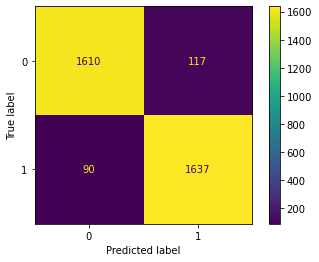

F1 Random forest Score:0.9346330275229358


<Figure size 432x288 with 0 Axes>

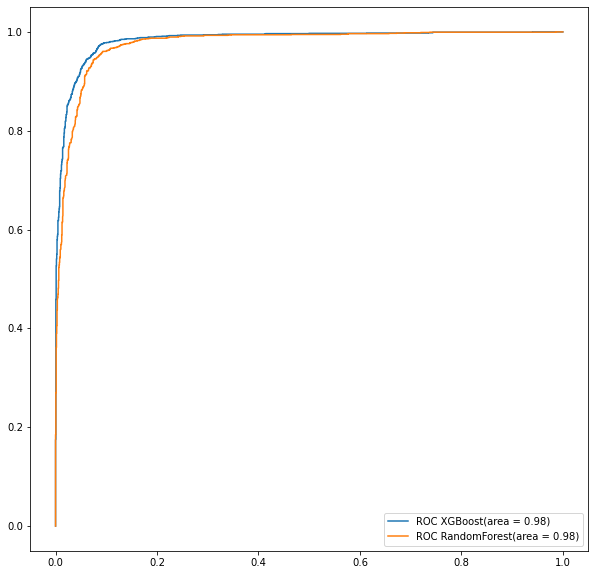

<Figure size 432x288 with 0 Axes>

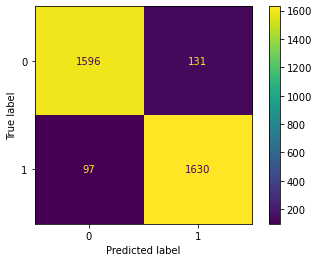

'\npredictions = selection_model.predict(X_eval_f)\naccuracy = accuracy_score(y_eval, predictions)\n\npredictions_train = selection_model.predict(X_train_f)\naccuracy_train = accuracy_score(y_train, predictions_train)\n\nselect_df_test = selection.transform(df_test_scaled)\npredictions_df_test = selection_model.predict(select_df_test)\naccuracy_df_test = accuracy_score(target_test, predictions_df_test)\n'

In [43]:
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, accuracy_score, average_precision_score
from sklearn.metrics import plot_confusion_matrix
objective = "multi:softprob"
learning_rate = 0.078
n_estimators = 490
max_depth = 4
colsample_bytree = 0.5
eval_metric = "aucpr"

model_scores = {"test": [], "train": [], "unseen":[]}

c = 0

filename = "../data/features_large_with_words.csv"

df, target, df_test, target_test = read_data(filename, verbose=True)

X_train, X_eval, y_train, y_eval = train_test_split(df, target, test_size=0.30,stratify=target)

# scale data separatly
X_train, X_eval, df_test_scaled = scale_data(X_train, X_eval, df_test)

# oversamplong clean on training set
X_train, y_train = oversample(X_train, y_train)
#oversampling clean on evaluation set
X_eval, y_eval = oversample(X_eval, y_eval)



model = XGBClassifier(objective=objective,
                        num_class=2,
                        learning_rate=learning_rate,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        colsample_bytree=colsample_bytree,
                        eval_metric=eval_metric,  # "rmse",
                        use_label_encoder=False)
model.fit(X_train,y_train)

selection = SelectFromModel(model, threshold=-np.inf, max_features=206,prefit=True)

X_train_f = selection.transform(X_train)
X_eval_f = selection.transform(X_eval)
#print("Shape:{}".format(X_train_f.shape[1]))

# train model
selection_model = XGBClassifier(objective=objective,
                        num_class=2,
                        learning_rate=learning_rate,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        colsample_bytree=colsample_bytree,
                        eval_metric=eval_metric,  # "rmse",
                        use_label_encoder=False)
selection_model.fit(X_train_f, y_train)
# eval model





rf_opt_pred_prob = selection_model.predict_proba(X_eval_f)
print("F1 XGboost Score:{}".format(f1_score(y_eval, selection_model.predict(X_eval_f))))

plot_confusion_matrix(selection_model, X_eval_f, y_eval)  
plt.show()
plt.clf()
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_eval, rf_opt_pred_prob[:, 1])
roc_auc_xg = auc(fpr_xg, tpr_xg)
#random forest
n_estimators = 150
ccp_alpha = 0.00007
min_samples_split = 2

model = RandomForestClassifier(n_estimators=n_estimators,
                                criterion='gini',
                                ccp_alpha=ccp_alpha, #best 0.0001 - 0.00005
                                min_samples_split=min_samples_split) #best 
model.fit(X_train,y_train)

selection = SelectFromModel(model, threshold=-np.inf, max_features=102,prefit=True)
X_train_f = selection.transform(X_train)
X_eval_f = selection.transform(X_eval)
#print("Shape:{}".format(X_train_f.shape[1]))

# train model
selection_model = RandomForestClassifier(n_estimators=n_estimators,
                            criterion='gini',
                            ccp_alpha=ccp_alpha, #best 0.0001 - 0.00005
                            min_samples_split=min_samples_split) #best 

selection_model.fit(X_train_f, y_train)

rf_opt_pred_prob = selection_model.predict_proba(X_eval_f)

print("F1 Random forest Score:{}".format(f1_score(y_eval, selection_model.predict(X_eval_f))))

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_eval, rf_opt_pred_prob[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fig = plt.figure(figsize=(10, 10))
lw = 2
plt.plot(fpr_xg, tpr_xg, label='ROC XGBoost(area = %0.2f)' % (roc_auc_xg))
plt.plot(fpr_rf, tpr_rf, label='ROC RandomForest(area = %0.2f)' % (roc_auc_rf))
plt.legend()

plt.show()
plt.clf()
plot_confusion_matrix(selection_model, X_eval_f, y_eval)  
plt.show()


"""
predictions = selection_model.predict(X_eval_f)
accuracy = accuracy_score(y_eval, predictions)

predictions_train = selection_model.predict(X_train_f)
accuracy_train = accuracy_score(y_train, predictions_train)

select_df_test = selection.transform(df_test_scaled)
predictions_df_test = selection_model.predict(select_df_test)
accuracy_df_test = accuracy_score(target_test, predictions_df_test)
"""

## K-Fold Cross Validation Version 2 (manual implementation of K-fold)
 - Select features at each fold based by train split , each iteration select new features
 - at the end of execution make stratified 70/30 split with union of all selected features

In [178]:
#---------------------------------------------------------------------------
#FLAG -> 1: that can be executed at any machine with final csv file and 
#--------------------------------------------------------------------------

#read csv file data with oversampling
#filename = "../data/features_large_lexical.csv"
#df, target, df_test,target_test = read_data(filename)



def k_fold_val_2(number_of_features, 
                 objective="multi:softprob",
                 num_class = 2,
                 learning_rate =0.2,
                 n_estimators=100,
                 max_depth=5,
                 colsample_bytree = 0.7,
                 eval_metric="aucpr"#"rmse"
                                           ):
    accur_scores = []
    accur_scores_train = []
    accur_scores_unseen = []
    #create Strafied 5 fold class
    kf = StratifiedKFold(n_splits=5,shuffle=True)
    all_features = None
    for folds in range(5):
        filename = "../data/features_large_lexical.csv"
        df, target, df_test,target_test = read_data(filename)

        #print("Alpha:{:.6f}".format(number_of_features))

        #make 5 fold cross valdation with use of features selected by train split

        for train_index, test_index in kf.split(df,target):
            X_train = df.iloc[train_index]
            X_train, X_test, y_train, y_test = df.iloc[train_index], df.iloc[test_index], target[train_index], target[test_index]

            #select K features with use of random forest feature selection
            X_train_f, ft = rforest_features(X_train, y_train, number_of_features)
            #X_train_f, ft = lasso(X_train, y_train, alpha=number_of_features)
            if all_features == None:
                all_features = set(ft)
            else:
                all_features = all_features.intersection(set(ft))
            #for f in ft:
            #    all_features.append(f)

            #keep only selected features in train and test splits
            X_test_f = X_test[ft]
            """
            #another classifiers for cross validation, that have pour performance till now
            reg_scores = cross_val_score(LogisticRegression(max_iter=10000,penalty='l1',
                                                            solver='liblinear',C=1.0), X, target,cv=5)

            svc_scores = cross_val_score(SVC(kernel='rbf', C=0.9), X, target,cv=5)

            for_scores = cross_val_score(RandomForestClassifier(n_estimators=35,
                                                                criterion='gini',
                                                                ccp_alpha=0.0003,
                                                                min_samples_split=4), X, target,cv=5)

            """
            xGb_cl = XGBClassifier(objective=objective,
                                   num_class = num_class,
                                   learning_rate =learning_rate,
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   colsample_bytree = colsample_bytree,
                                   eval_metric=eval_metric,#"rmse",
                                   use_label_encoder=False)
            #fit model with train dataset
            xGb_cl.fit(X_train_f, y_train)

            #predict test dataset and keep prediction labels
            pred = xGb_cl.predict(X_test_f)
            pred_train = xGb_cl.predict(X_train_f)
            pred_unseen = xGb_cl.predict(df_test[ft])
            #print("Fold accuracy score: ",accuracy_score(y_test, pred))
            accur_scores.append(accuracy_score(y_test, pred))
            accur_scores_train.append(accuracy_score(y_train, pred_train))
            accur_scores_unseen.append(accuracy_score(target_test, pred_unseen))
    #print(all_features)
    accur_scores = sum(accur_scores) / len(accur_scores)
    accur_scores_train = sum(accur_scores_train) / len(accur_scores_train)
    accur_scores_unseen = sum(accur_scores_unseen) / len(accur_scores_unseen)
    #print("Avg k-fold:{} for :{} features".format(accur_scores, number_of_features))
    #plt.figure(num=None, figsize=(60, 60))
    #list_features = list(set(all_features))
    #print(len(list_features))
    #print(len(ft))
    
    #count_features = [all_features.count(f) for f in list_features]
    #print(count_features)
    #plt.bar(range(len(list_features)), count_features)
    #plt.xticks(range(len(list_features)), list_features, rotation=45)
    #plt.savefig("features.png",dpi=600)

    #after k-folds keep all selected features and make 70/30 stratified split and train and predict
    all_features = list(set(all_features))
    #print("70/30")
    """
    X_train, X_test, y_train, y_test = train_test_split(df[all_features], 
                                                        target,
                                                        test_size=0.3,
                                                        stratify=target)

    xGb_cl = XGBClassifier(objective="multi:softprob",
                           num_class = 2,
                           learning_rate =0.2,
                           n_estimators=100,
                           max_depth=5,
                           colsample_bytree = 0.7,
                           eval_metric="aucpr",#"rmse",
                           use_label_encoder=False)

    xGb_cl.fit(X_train, y_train)
    pred = xGb_cl.predict(X_test)
    print("Final accuracy score:",accuracy_score(y_test, pred),"\n--------------\n")
    return accur_scores, accuracy_score(y_test, pred)
    """
    return accur_scores, accur_scores_train, accur_scores_unseen

#k_fold_val_2(number_of_features=80,n_rep=1)

## Parameter fine tuning

In [181]:
#---------------------------------------------------------------------------
#FLAG -> 1: that can be executed at any machine with final csv file and 
#--------------------------------------------------------------------------
#good one 
#------------------------------------------
#LR: 0.1
#nEst: 150
#m_depth: 7
#bytree: 0.7
#ev_m: aucpr score avg:0.9394461205162186
#-----------------------------------------

"""
learning_rate =[0.1,0.2,0.3,0.4]
n_estimators=[50,100, 150,200,250,300,350]
max_depth=[1,2,3,4,5,6,7,8,9,10,15,20]
colsample_bytree = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
eval_metric=["rmse","auc"]
"""

#print(df.shape)
values = list(np.arange(0.00080, 0.002, 0.00001))
values=list(range(40,50))
#X,ft = lasso(df, target, alpha=0.02)
#print(len(ft))

#plt.figure(figsize=(8.0,8.0))
k_scores = defaultdict(lambda: 0)

objective=["multi:softprob","multi:softprob","reg:squarederror","reg:squaredlogerror", 
           "binary:logistic","binary:logitraw","binary:hinge"]
learning_rate =[0.08, 0.1, 0.13]
n_estimators=[150, 200, 250,300]
max_depth=[5,6,7,8]
colsample_bytree = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]


objective=["multi:softprob"]#,"multi:softmax"]
learning_rate =[0.07,0.08,0.09]
n_estimators=[150,200,300,350]
max_depth=[4,5,6]
colsample_bytree = [0.45,0.5,0.55,0.6,0.65]

eval_metric=["aucpr"]
for obj in objective:
    for lr in learning_rate:
        for n_est in n_estimators:
            for m_depth in max_depth:
                for bytree in colsample_bytree:
                    
                    for ev_m in eval_metric:
                        k_scores = []
                        k_scores_train = []
                        k_scores_unseen = []
                        f_scores = []
                        for rnd in range(3):
                            k_accuracy, k_accuracy_train, k_accuracy_unseen = k_fold_val_2(number_of_features=45, 
                                                                        objective=obj,
                                                                       num_class = 2,
                                                                       learning_rate =lr,
                                                                       n_estimators=n_est,
                                                                       max_depth=m_depth,
                                                                       colsample_bytree = bytree,
                                                                       eval_metric=ev_m)
                            #k_accuracy, full_accuracy = k_fold_val_2(number_of_features=alpha)
                            k_scores.append(k_accuracy)
                            k_scores_train.append(k_accuracy_train)
                            k_scores_unseen.append(k_accuracy_unseen)
                        
                        #f_scores.append(full_accuracy)
                        f_out = open("param_ftune.txt","a+")
                        f_out.write("Obj:{}\nLR: {}\nnEst: {}\nm_depth: {}\nbytree: {}\nev_m: {} score avg:{} score train:{} avg unseen:{}\n------------\n".format(
                                            obj,
                                            lr,
                                            n_est, 
                                            m_depth,
                                            bytree, 
                                            ev_m, 
                                            sum(k_scores)/len(k_scores),
                                            sum(k_scores_train)/len(k_scores_train),
                                            sum(k_scores_unseen)/len(k_scores_unseen)) )
                        f_out.close()

                        #if sum(k_scores)/len(k_scores) >= 0.938:
                        print("Obj:{}\nLR: {}\nnEst: {}\nm_depth: {}\nbytree: {}\nev_m: {} score avg_test:{} avg_train:{} avg unseen:{}".format(
                                            obj,
                                            lr,
                                            n_est, 
                                            m_depth,
                                            bytree, 
                                            ev_m, 
                                            sum(k_scores)/len(k_scores),
                                            sum(k_scores_train)/len(k_scores_train),
                                            sum(k_scores_unseen)/len(k_scores_unseen)) )

#res = []
#for alpha in values:
#    res.append(k_scores[alpha] / 10)
#plt.plot(values, res, label="K-Fold")
#plt.plot(values,f_scores, label="Full Split 70/30")
#plt.legend()
#plt.xticks(rotation=45)
#plt.savefig("Lasso_feature.png",dpi=600)


#features = list(range(2,167))
#accuracy_fold = []
#accuracy_split = []
#for f_number in features:
#    acc_s, acc_s_s = k_fold_val_2(number_of_features=f_number,n_rep=10)
#    accuracy_fold.append(acc_s)
#    accuracy_split.append(acc_s_s)
#plt.plot(features, accuracy_fold, label="K-Fold avg accuracy")
#plt.plot(features, accuracy_split, label="70/30 split accuracy")


Obj:multi:softprob
LR: 0.07
nEst: 150
m_depth: 4
bytree: 0.45
ev_m: aucpr score avg_test:0.9308 avg_train:0.9502238095238096 avg unseen:0.9294763513513514
Obj:multi:softprob
LR: 0.07
nEst: 150
m_depth: 4
bytree: 0.5
ev_m: aucpr score avg_test:0.9310031746031745 avg_train:0.9505333333333333 avg unseen:0.9294031531531534
Obj:multi:softprob
LR: 0.07
nEst: 150
m_depth: 4
bytree: 0.55
ev_m: aucpr score avg_test:0.9310349206349207 avg_train:0.9504587301587302 avg unseen:0.9290033783783782
Obj:multi:softprob
LR: 0.07
nEst: 150
m_depth: 4
bytree: 0.6
ev_m: aucpr score avg_test:0.9305079365079366 avg_train:0.9505904761904763 avg unseen:0.9289414414414413
Obj:multi:softprob
LR: 0.07
nEst: 150
m_depth: 4
bytree: 0.65
ev_m: aucpr score avg_test:0.9314857142857145 avg_train:0.9507761904761903 avg unseen:0.929222972972973
Obj:multi:softprob
LR: 0.07
nEst: 150
m_depth: 4
bytree: 0.7
ev_m: aucpr score avg_test:0.931015873015873 avg_train:0.9513126984126985 avg unseen:0.9293693693693695
Obj:multi:softp

Obj:multi:softprob
LR: 0.07
nEst: 300
m_depth: 6
bytree: 0.55
ev_m: aucpr score avg_test:0.9350603174603175 avg_train:0.9882730158730157 avg unseen:0.9306925675675676
Obj:multi:softprob
LR: 0.07
nEst: 300
m_depth: 6
bytree: 0.6
ev_m: aucpr score avg_test:0.9348634920634922 avg_train:0.9882904761904762 avg unseen:0.9306756756756757
Obj:multi:softprob
LR: 0.07
nEst: 300
m_depth: 6
bytree: 0.65
ev_m: aucpr score avg_test:0.934615873015873 avg_train:0.9884174603174603 avg unseen:0.930259009009009
Obj:multi:softprob
LR: 0.07
nEst: 300
m_depth: 6
bytree: 0.7
ev_m: aucpr score avg_test:0.9348825396825396 avg_train:0.9887396825396827 avg unseen:0.9306531531531531
Obj:multi:softprob
LR: 0.07
nEst: 350
m_depth: 4
bytree: 0.45
ev_m: aucpr score avg_test:0.9341523809523808 avg_train:0.9668412698412698 avg unseen:0.9311373873873876
Obj:multi:softprob
LR: 0.07
nEst: 350
m_depth: 4
bytree: 0.5
ev_m: aucpr score avg_test:0.933815873015873 avg_train:0.9673873015873015 avg unseen:0.9310641891891892
Obj:

Obj:multi:softprob
LR: 0.08
nEst: 150
m_depth: 5
bytree: 0.65
ev_m: aucpr score avg_test:0.9332952380952381 avg_train:0.9651238095238094 avg unseen:0.9302252252252251
Obj:multi:softprob
LR: 0.08
nEst: 150
m_depth: 5
bytree: 0.7
ev_m: aucpr score avg_test:0.9332444444444445 avg_train:0.9651460317460318 avg unseen:0.9305461711711711
Obj:multi:softprob
LR: 0.08
nEst: 150
m_depth: 6
bytree: 0.45
ev_m: aucpr score avg_test:0.9339428571428571 avg_train:0.9748714285714285 avg unseen:0.9312331081081081
Obj:multi:softprob
LR: 0.08
nEst: 150
m_depth: 6
bytree: 0.5
ev_m: aucpr score avg_test:0.9337968253968253 avg_train:0.9750698412698412 avg unseen:0.9308277027027027
Obj:multi:softprob
LR: 0.08
nEst: 150
m_depth: 6
bytree: 0.55
ev_m: aucpr score avg_test:0.9340000000000002 avg_train:0.9752238095238095 avg unseen:0.9312162162162164
Obj:multi:softprob
LR: 0.08
nEst: 150
m_depth: 6
bytree: 0.6
ev_m: aucpr score avg_test:0.9333079365079365 avg_train:0.9751698412698412 avg unseen:0.9305855855855856
O

Obj:multi:softprob
LR: 0.08
nEst: 350
m_depth: 5
bytree: 0.45
ev_m: aucpr score avg_test:0.9349142857142857 avg_train:0.9834349206349207 avg unseen:0.9305405405405405
Obj:multi:softprob
LR: 0.08
nEst: 350
m_depth: 5
bytree: 0.5
ev_m: aucpr score avg_test:0.9351492063492062 avg_train:0.9836904761904762 avg unseen:0.9307319819819818
Obj:multi:softprob
LR: 0.08
nEst: 350
m_depth: 5
bytree: 0.55
ev_m: aucpr score avg_test:0.9350920634920635 avg_train:0.984115873015873 avg unseen:0.9302984234234234
Obj:multi:softprob
LR: 0.08
nEst: 350
m_depth: 5
bytree: 0.6
ev_m: aucpr score avg_test:0.9350412698412699 avg_train:0.9842206349206349 avg unseen:0.9303772522522523
Obj:multi:softprob
LR: 0.08
nEst: 350
m_depth: 5
bytree: 0.65
ev_m: aucpr score avg_test:0.9353142857142857 avg_train:0.9849190476190478 avg unseen:0.9306531531531532
Obj:multi:softprob
LR: 0.08
nEst: 350
m_depth: 5
bytree: 0.7
ev_m: aucpr score avg_test:0.934152380952381 avg_train:0.984952380952381 avg unseen:0.9303153153153154
Obj:

Obj:multi:softprob
LR: 0.09
nEst: 200
m_depth: 4
bytree: 0.55
ev_m: aucpr score avg_test:0.9330666666666665 avg_train:0.9608222222222222 avg unseen:0.9305799549549549
Obj:multi:softprob
LR: 0.09
nEst: 200
m_depth: 4
bytree: 0.6
ev_m: aucpr score avg_test:0.9332444444444444 avg_train:0.9611936507936508 avg unseen:0.9305855855855856
Obj:multi:softprob
LR: 0.09
nEst: 200
m_depth: 4
bytree: 0.65
ev_m: aucpr score avg_test:0.9334539682539682 avg_train:0.9612603174603175 avg unseen:0.9306193693693693
Obj:multi:softprob
LR: 0.09
nEst: 200
m_depth: 4
bytree: 0.7
ev_m: aucpr score avg_test:0.9333650793650795 avg_train:0.9614126984126985 avg unseen:0.9303828828828827
Obj:multi:softprob
LR: 0.09
nEst: 200
m_depth: 5
bytree: 0.45
ev_m: aucpr score avg_test:0.9337460317460318 avg_train:0.9723317460317461 avg unseen:0.9309515765765766
Obj:multi:softprob
LR: 0.09
nEst: 200
m_depth: 5
bytree: 0.5
ev_m: aucpr score avg_test:0.9337142857142856 avg_train:0.9731285714285715 avg unseen:0.9307713963963965
O

Obj:multi:softprob
LR: 0.09
nEst: 350
m_depth: 6
bytree: 0.65
ev_m: aucpr score avg_test:0.934647619047619 avg_train:0.9967158730158728 avg unseen:0.9301351351351351
Obj:multi:softprob
LR: 0.09
nEst: 350
m_depth: 6
bytree: 0.7
ev_m: aucpr score avg_test:0.9348063492063491 avg_train:0.9971412698412698 avg unseen:0.9300619369369368
Obj:multi:softprob
LR: 0.09
nEst: 400
m_depth: 4
bytree: 0.45
ev_m: aucpr score avg_test:0.9340634920634922 avg_train:0.9761650793650795 avg unseen:0.9307770270270268
Obj:multi:softprob
LR: 0.09
nEst: 400
m_depth: 4
bytree: 0.5
ev_m: aucpr score avg_test:0.9346412698412698 avg_train:0.9764365079365079 avg unseen:0.9310472972972974
Obj:multi:softprob
LR: 0.09
nEst: 400
m_depth: 4
bytree: 0.55
ev_m: aucpr score avg_test:0.9344634920634921 avg_train:0.9770571428571428 avg unseen:0.9307150900900901
Obj:multi:softprob
LR: 0.09
nEst: 400
m_depth: 4
bytree: 0.6
ev_m: aucpr score avg_test:0.9343809523809524 avg_train:0.9771444444444445 avg unseen:0.9306531531531532
Ob

Obj:multi:softprob
LR: 0.1
nEst: 200
m_depth: 6
bytree: 0.45
ev_m: aucpr score avg_test:0.9354031746031746 avg_train:0.9870555555555556 avg unseen:0.9313288288288288
Obj:multi:softprob
LR: 0.1
nEst: 200
m_depth: 6
bytree: 0.5
ev_m: aucpr score avg_test:0.9343619047619048 avg_train:0.9871555555555555 avg unseen:0.9310529279279279
Obj:multi:softprob
LR: 0.1
nEst: 200
m_depth: 6
bytree: 0.55
ev_m: aucpr score avg_test:0.9348253968253969 avg_train:0.9873920634920634 avg unseen:0.9310416666666664
Obj:multi:softprob
LR: 0.1
nEst: 200
m_depth: 6
bytree: 0.6
ev_m: aucpr score avg_test:0.9346920634920634 avg_train:0.9877507936507937 avg unseen:0.9308277027027027
Obj:multi:softprob
LR: 0.1
nEst: 200
m_depth: 6
bytree: 0.65
ev_m: aucpr score avg_test:0.9347365079365079 avg_train:0.9874666666666666 avg unseen:0.9299099099099098
Obj:multi:softprob
LR: 0.1
nEst: 200
m_depth: 6
bytree: 0.7
ev_m: aucpr score avg_test:0.9349841269841269 avg_train:0.988088888888889 avg unseen:0.9302927927927928
Obj:mult

KeyboardInterrupt: 

In [ ]:
filename = "../data/features_large_lexical.csv"
df, target, df_test,target_test = read_data(filename)
X_train, X_test, y_train, y_test = train_test_split(df, target,random_state=0,test_size=0.2,stratify=target)


objective="multi:softprob"
learning_rate =0.07
n_estimators=300
max_depth=5
colsample_bytree = 0.45
eval_metric="aucpr"
model = XGBClassifier(objective=objective,
                                   num_class = 2,
                                   learning_rate =learning_rate,
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   colsample_bytree = colsample_bytree,
                                   eval_metric=eval_metric,#"rmse",
                                   use_label_encoder=False)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_test)
predictions_unseen = model.predict(df_test)
accuracy = accuracy_score(y_test, predictions)
accuracy_unseen = accuracy_score(target_test, predictions_unseen)
print("Accuracy test: {} Accuracy unseen: {}".format(accuracy, accuracy_unseen))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(objective=objective,
                                   num_class = num_class,
                                   learning_rate =learning_rate,
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   colsample_bytree = colsample_bytree,
                                   eval_metric=eval_metric,#"rmse",
                                   use_label_encoder=False)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    select_X_unseen = selection.transform(df_test)
    predictions_unseen = selection_model.predict(select_X_unseen)
    accuracy_unseen = accuracy_score(target_test, predictions_unseen)
    print("Thresh={}, n={}, Accuracy test: {} Accuracy unseen: {}".format(thresh, select_X_train.shape[1], accuracy, accuracy_unseen))


In [105]:
X_train, X_test, y_train, y_test = train_test_split(df, target,random_state=0,test_size=0.2)
X_train_f, ft = rforest_features(X_train, y_train, 95)
#X_train_f, ft = lasso(X_train, y_train, alpha=number_of_features)

#for f in ft:
#    all_features.append(f)

#keep only selected features in train and test splits
X_test_f = X_test[ft]
"""
#another classifiers for cross validation, that have pour performance till now
reg_scores = cross_val_score(LogisticRegression(max_iter=10000,penalty='l1',
                                                solver='liblinear',C=1.0), X, target,cv=5)

svc_scores = cross_val_score(SVC(kernel='rbf', C=0.9), X, target,cv=5)

for_scores = cross_val_score(RandomForestClassifier(n_estimators=35,
                                                    criterion='gini',
                                                    ccp_alpha=0.0003,
                                                    min_samples_split=4), X, target,cv=5)

"""
xGb_cl = XGBClassifier(objective="multi:softprob",
                               random_state = 10,
                               num_class = 2,
                               learning_rate =0.02,
                               n_estimators=700,
                               max_depth=8,
                               min_child_weight=1,
                               reg_alpha = 0.4,
                               #reg_lambda = 1,
                               #colsample_bytree = 0.7,
                               eval_metric="aucpr",#"rmse",
                       use_label_encoder=False)

xGb_cl.fit(X_train_f, y_train)

#predict test dataset and keep prediction labels
pred = xGb_cl.predict(X_test_f)
pred_train = xGb_cl.predict(X_train_f)
#print("Fold accuracy score: ",accuracy_score(y_test, pred))
print("Test accuracy",accuracy_score(y_test, pred))
print("Train accuracy",accuracy_score(y_train, pred_train))

Test accuracy 0.9269684290604793
Train accuracy 0.9945781413488063


### Dimentionality reduction t-SNE

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


#X, _ = lasso_features(df, target, 4)
#X,_ = lasso(df, target, alpha=0.00002)
X = rforest_features(df, target, 56)
tsne_2d = make_tsne(X, target, "full dataset",learning_rate=100, perplexity=20)
#tsne_2d = make_tsne(X, target, "full dataset")
#tsne_2d = make_tsne(X, target, "full dataset")
#print("Plot t-SNE for train dataset with features selected from train portion")
#make_tsne(X_train_scaled, y_train, "train dataset")
#print("Plot t-SNE for test dataset with features selected from train portion")
#make_tsne(X_test_scaled, y_test, "test dataset")

### Dimentionality reduction UMAP

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

#X, _ = lasso_features(df, target, 4)
umap_2d = perofrm_umap_clustering(X, target, "all dataset")
#embedding = perofrm_umap_clustering(X, target, "all dataset")
#embedding = perofrm_umap_clustering(X, target, "all dataset")
#perofrm_umap_clustering(X_test_scaled, y_test,  "test dataset")
#perofrm_umap_clustering(X_train_scaled, y_train, "train dataset")

### Clustering DBSCAN

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

#dbscan_clustering(tsne_2d, 0.00557, 25)
#dbscan_clustering(tsne_2d, 0.0045, 25)
#dbscan_clustering(tsne_2d, 0.0057, 30)
#dbscan_clustering(umap_2d,0.007, 30)
#dbscan_clustering(umap_2d,0.0025, 20)
dbscan_clustering(umap_2d,0.0025, 20)
#dbscan_clustering(X, 0.00557, 25)


## Mean-Shift 

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

mean_shift(tsne_2d)

## Cosine Similarity

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


res = cosine_similarity(X,Y= None, dense_output=True)
pairs = set()
f_out = open("cosine_graph.dot","w+")
f_out.write("digraph {\n")
for i in range(0, res.shape[0]):
    f_out.write("\t\"{}\"     [label=\"{}\"];\n".format(i,i))
    #    "1" -- "2" [weight=100];")
for i in range(0,res.shape[0]):
    max_sim = res[i,list(set(range(0,39123)) - set([i]))]
    max_sim = [x for x in max_sim if x >= 0.9]
    if len(max_sim) == 0:
        continue
    max_sim.sort(reverse=True)
    if len(max_sim) > 5:
        max_sim = max_sim[:5]
    
    
    #print(max_sim)
    #print(np.where(res[1,:] == max_sim))
    for m_value in max_sim:
        line = "\t\"{}\" -- \"{}\" [weight={}];\n".format(i, np.where(res[i,:] == m_value)[0][0], int(m_value*100.0))
        line_rev = "\t\"{}\" -- \"{}\" [weight={}];\n".format(np.where(res[i,:] == m_value)[0][0], i, int(m_value*100.0))
        if line in pairs or line_rev in pairs:
            continue
        pairs.add(line)
        #print(line)
        f_out.write(line)
f_out.write("}")
f_out.close()

## GaussianMixture

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


gmm = GaussianMixture(n_components=2,n_init=100,init_params = "kmeans",covariance_type = "full")
#X, _ = lasso_features(df, target, 10)
#X = kbest_features(df, target, 3)
gmm.fit(X)

#predictions from gmm
labels = gmm.predict(X)
TP = [True if labels[i]==1 and target[i] == 1 else False for i in range(len(target)) ].count(True)
TN = [True if labels[i]==0 and target[i] == 0 else False for i in range(len(target)) ].count(True)
FP = [True if labels[i]==1 and target[i] == 0 else False for i in range(len(target)) ].count(True)
FN = [True if labels[i]==0 and target[i] == 1 else False for i in range(len(target)) ].count(True)
P = len(target[target == 1])
N = len(target[target == 0])
print("True pos :{} tp rate:{}".format(TP,TP/P))
print("True neg :{} tn rate:{}".format(TN, TN/N))
print("False pos :{} fp rate:{}".format(FP,FP/N))
print("False neg :{} fn rate:{}".format(FN,FN/P))

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

#X = lasso_features(df, target, 4)
#X = rforest_features(df, target, 4)
TPR_L = []
TNR_L = []
FNR_L = []
FPR_L = []
purity = []
#for n_features in range(1,10):
for j in range(2,40):
    #X = kbest_features(df, target, n_features)
    X, _ = lasso_features(df, target, 4)
    #X = rforest_features(df, target, 4)
   
    TPR = []
    TNR = []
    FPR = []
    FNR = []
    tmp_pur = []
    for k in range(0,10):
        gmm = GaussianMixture(n_components=j,init_params = "kmeans",covariance_type = "full")
        gmm.fit(X)

        #predictions from gmm
        labels = gmm.predict(X)
        tmp_pur.append(compute_pur(labels,target))
        TP = [True if labels[i]==1 and target[i] == 2 else False for i in range(len(target)) ].count(True)
        TN = [True if labels[i]==0 and target[i] == 0 else False for i in range(len(target)) ].count(True)
        FP = [True if labels[i]==1 and target[i] == 0 else False for i in range(len(target)) ].count(True)
        FN = [True if labels[i]==0 and target[i] == 2 else False for i in range(len(target)) ].count(True)
        P = len(target[target == 2])
        N = len(target[target == 0])
        TPR.append(TP/P)
        TNR.append(TN/N)
        FPR.append(FP/N)
        FNR.append(FN/P)
    purity.append(sum(tmp_pur) / len(tmp_pur))
    TPR = sum(TPR) / len(TPR)
    TNR = sum(TNR) / len(TNR)
    FPR = sum(FPR) / len(FPR)
    FNR = sum(FNR) / len(FNR)
    
    #print("Number of features:{} TPR:{} TNR:{} FNR:{} FPR:{}".format(n_features, TPR, TNR, FNR, FPR))
    TPR_L.append(TPR)
    TNR_L.append(TNR)
    FNR_L.append(FNR)
    FPR_L.append(FPR)
plt.figure(figsize=(12.0,12.0))
plt.plot(range(1,len(TPR_L)+1) ,TPR_L, label="True Positive", color="Blue" )
plt.plot(range(1,len(TNR_L)+1) ,TNR_L, label="True Negative", color="Green" )
plt.plot(range(1,len(FNR_L)+1) ,FNR_L, label="False Negative", color="Red")
plt.plot(range(1,len(FPR_L)+1) ,FPR_L, label="False Positive" , color ="y")
plt.xticks(range(1,len(FPR_L)+1))
plt.xlabel("Number of cluster")
plt.legend()
plt.show()
plt.clf()
plt.figure(figsize=(12.0,12.0))
plt.plot(range(2,40),purity, label="Purity avg")
plt.title("Avg cluster purity")
plt.show()
print(1+TPR_L.index(max(TPR_L)))
print(1+TNR_L.index(max(TNR_L)))
print(1+FNR_L.index(min(FNR_L)))
print(1+FPR_L.index(min(FPR_L)))


    
    


### Anomaly detection


In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------



X, _ = lasso_features(df, target, 4)
X_s = X[target==0,:]
print(X_s.shape)
cov = EllipticEnvelope().fit(X)
res = cov.predict(X)
print(len(target))
labels = [target[i] for i in range(len(res)) if res[i] == -1]

print("Wrong:",labels.count(0))
print("Right:",labels.count(2))
gm = GaussianMixture(n_components=2)
gm.fit(X)
densities = gm.score_samples(X)
print(len(densities))
density_threshold = np.percentile(densities, 4)
anomalies = np.where(densities < density_threshold)[0]
labels = [target[i] for i in anomalies]
print(labels.count(0))
print(labels.count(2))
#print(anomalies)

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


from sklearn.mixture import BayesianGaussianMixture
X, _ = lasso_features(df, target, 4)
print(set(target))
bgm = BayesianGaussianMixture(n_components=3, n_init=10, random_state=0,covariance_type='tied',init_params='kmeans')
bgm.fit(X)
labels = bgm.predict(X)

labels[target == 2]

TP = [True if labels[i]==2 and target[i] == 2 else False for i in range(len(target)) ].count(True)
TN = [True if labels[i]==0 and target[i] == 0 else False for i in range(len(target)) ].count(True)
FP = [True if labels[i]==2 and target[i] == 0 else False for i in range(len(target)) ].count(True)
FN = [True if labels[i]==0 and target[i] == 2 else False for i in range(len(target)) ].count(True)
P = len(target[target == 2])
N = len(target[target == 0])
print("True pos :{} tp rate:{}".format(TP,TP/P))
print("True neg :{} tn rate:{}".format(TN, TN/N))
print("False pos :{} fp rate:{}".format(FP,FP/N))
print("False neg :{} fn rate:{}".format(FN,FN/P))



In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


# calculate interquartile range
def remove_outliers(data, labels):
    all_outliers = set()
    for i in range(data.shape[1]):
        q25, q75 = np.percentile(data[:,i], 25), np.percentile(data[:,i], 75)
        iqr = q75 - q25
        # calculate the outlier cutoff
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        # identify outliers
        outliers = set()
        for x in data[:,i]:
            if x < lower or x > upper:
                outliers = set(np.where(data[:,i] == x)[0]).union(outliers)
        #outliers = [np.where(X[:,i] == x)[0] for x in X[:,i] if x < lower or x > upper]
        #print(len(outliers))
        #print(len(set(outliers)))
        all_outliers = all_outliers.union(outliers)
    #print("----")
    #print(len(all_outliers))
    l = [labels[i] for i in all_outliers]
    #print(l.count(0))
    #print(l.count(1))
    #print(l.count(2))
    ind_clear = list(set(range(X.shape[0])) -all_outliers)
    X_clear = data[ind_clear,:]
    target_clear = labels[ind_clear]
    #print(X_clear.shape)
    return X_clear, target_clear
#print(len(outliers))
#print(target[outliers])

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

from sklearn.mixture import BayesianGaussianMixture
#X, _ = lasso_features(df, target, 4)
print(set(target))
#bgm = BayesianGaussianMixture(n_components=3, n_init=10, random_state=0,covariance_type='tied',init_params='kmeans')
bgm = GaussianMixture(n_components=3, n_init=10,max_iter=1000, random_state=0,covariance_type = "full",init_params='kmeans')

bgm.fit(X_clear)
labels = bgm.predict(X_clear)

print(labels[target_clear == 2])

TP = [True if labels[i]==2 and target_clear[i] == 2 else False for i in range(len(target_clear)) ].count(True)
TN = [True if labels[i]==0 and target_clear[i] == 0 else False for i in range(len(target_clear)) ].count(True)
FP = [True if labels[i]==2 and target_clear[i] == 0 else False for i in range(len(target_clear)) ].count(True)
FN = [True if labels[i]==0 and target_clear[i] == 2 else False for i in range(len(target_clear)) ].count(True)
P = len(target_clear[target_clear == 2])
N = len(target_clear[target_clear == 0])
print("True pos :{} tp rate:{}".format(TP,TP/P))
print("True neg :{} tn rate:{}".format(TN, TN/N))
print("False pos :{} fp rate:{}".format(FP,FP/N))
print("False neg :{} fn rate:{}".format(FN,FN/P))

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


r = labels[target_clear == 2]
print(len(np.where(r == 0)[0]))
print(len(np.where(r == 1)[0]))
print(len(np.where(r == 2)[0]))
print("------------")
r = labels[target_clear == 1]
print(len(np.where(r == 0)[0]))
print(len(np.where(r == 1)[0]))
print(len(np.where(r == 2)[0]))
print("------------")
r = labels[target_clear == 0]
print(len(np.where(r == 0)[0]))
print(len(np.where(r == 1)[0]))
print(len(np.where(r == 2)[0]))

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

df, target, user_ids = read_data("features_large_extra.csv")
#new_lb = { int(i.split(" ")[0]) : int(i.split(" ")[1]) for i in open('labels_sample.txt','r').read().split("\n") if i != ''}
#new_target = np.array([new_lb[user_ids[u]] for u in range(len(user_ids))])
#print(new_target.shape)
print(target.shape)
#X, _ = lasso_features(df, target, 5)
#X = rforest_features(df, target, 5)
#X = kbest_features(df, new_target, 5)
#X_clear, target_clear = remove_outliers(X, target)
#clusters = dbscan_clustering(X_clear, 0.03, 25)
#print(set(clusters))
#cc = defaultdict(lambda: set())
#for i in range(len(clusters)):
#    cc[clusters[i]].add(i)
#g_1 = set(np.where(target_clear == 1)[0])
#g_2 = set(np.where(target_clear == 2)[0])
#g_0 = set(np.where(target_clear == 0)[0])
#for c in cc:
#    if c == -1:
#        continue
#    print(" Inter g_0: {} g_1: {} g_2: {}".format(len(g_0.intersection(cc[c])),  len(g_1.intersection(cc[c])), len(g_2.intersection(cc[c])) ))
    

for f in range(1,10):
    bic = []
    aic=[]
    plt.figure(figsize=(12.0,12.0))
    X, _ = lasso_features(df, target, f)
    print("Features:{}".format(f))
    for n in range(1,50):
        bgm = GaussianMixture(n_components=n, n_init=10,max_iter=10000, random_state=0,covariance_type = "tied",init_params='kmeans')

        bgm.fit(X)
        bic.append(bgm.bic(X))
        aic.append(bgm.aic(X))
    plt.plot(range(len(bic)), bic,label="Bic")
    plt.plot(range(len(aic)), aic,label="Aic")
    plt.legend()
    plt.savefig("GM_f_{}_tied.png".format(f))
    plt.clf()
#accuracy_score(target, labels)

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
df, target, user_ids = read_data("features_large_extra.csv")

print(target.shape)
#X, _ = lasso_features(df, target, 5)
#X = rforest_features(df, target, 5)
#X = kbest_features(df, new_target, 5)
#X_clear, target_clear = remove_outliers(X, target)

score = []
inhert = []
aic=[]
purity = []
avg_cl_size = []
plt.figure(figsize=(12.0,12.0))
X, _ = lasso_features(df, target, 50)
clusters = range(2,30)
for k in clusters:
    # Declaring Model
    model = KMeans(n_clusters=k)

    # Fitting Model
    model.fit(X)
    score.append(silhouette_score(X, model.labels_))
    inhert.append(model.inertia_)
    purity.append(compute_pur(model.labels_,target))
    avg_cl_size.append(compute_size(model.labels_))
plt.plot(  clusters, score)
plt.plot(  clusters, inhert)
plt.xticks(clusters,rotation=45)
plt.xlabel("K number")
plt.ylabel("Score")
plt.title("K-means scores for mutliple number of clusters")
plt.show()
plt.clf()
plt.figure(figsize=(12.0,12.0))

plt.plot( clusters, purity)
plt.title("Cluster purity")
plt.show()
plt.figure(figsize=(12.0,12.0))


plt.plot( clusters, avg_cl_size)
plt.title("Avg cluster size")
plt.show()


In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

#print(len(model.labels_))
#print(model.labels_[0])
#print(type(model.labels_[0]))
#print(type(target[1]))
#print(target[1])
def compute_pur(labels,target):
    d = defaultdict(lambda: [])
    for i in range(len(labels)):
        d[int(labels[i])].append(int(target[i]))
    cluster_purity = []
    for c in d:
        max_tar = max(d[c])
        cluster_purity.append(max_tar/len(d[c]))
    return sum(cluster_purity)/ len(cluster_purity)

def compute_size(labels):
    d = defaultdict(lambda: [])
    for i in range(len(labels)):
        d[int(labels[i])].append(int(target[i]))
    clusters = [len(d[x]) for x in d]
    
    return sum(clusters)/ len(clusters)

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


# Reading the DataFrame
#seeds_df = pd.read_csv(
#    "https://raw.githubusercontent.com/vihar/unsupervised-learning-with-python/master/seeds-less-rows.csv")

# Remove the grain species from the DataFrame, save for later
#varieties = list(seeds_df.pop('grain_variety'))

# Extract the measurements as a NumPy array
#samples = seeds_df.values

"""
Perform hierarchical clustering on samples using the
linkage() function with the method='complete' keyword argument.
Assign the result to mergings.
"""
mergings = linkage(X, method='complete')

"""
Plot a dendrogram using the dendrogram() function on mergings,
specifying the keyword arguments labels=varieties, leaf_rotation=90,
and leaf_font_size=6.
"""
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=6,
           )

plt.show()

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

X, _ = lasso_features(df, target, 4)
for i in range(10,250,10):
    print("i:{}".format(i))
    tsne_2d = make_tsne(X, target, "full dataset", learning_rate=350, perplexity=i)

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

df, target, user_ids = read_data("features_large_extra.csv")
X, _ = lasso_features(df, target, 4)


In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------

perofrm_umap_clustering(X, target,  "Full", n_neighbors=25, n_components=30)

In [ ]:
#---------------------------------------------------------------------------
#FLAG  -> 0: that cannot be executed in any machine, excpet Alex.
#--------------------------------------------------------------------------


scores = []
for j in range(100):
    df, target, user_ids = read_data("features_large_extra.csv")
    X = rforest_features(df, target, 40)
    for i in range(1000):
        clf = XGBClassifier(objective="multi:softprob",
                            num_class = 2,
                            learning_rate =0.2,
                            n_estimators=100,
                            max_depth=5,
                            colsample_bytree = 0.7,
                            eval_metric="rmse",
                            use_label_encoder=False)
        X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3,)
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test,y_test))
    
print("Avg score:{}".format(sum(scores)/len(scores)))

